# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_65828/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_65828/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_65828/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2, "sigma_b": 10,        #Ignored not used
    "RW2": { "tau_a": 2, "tau_b": 0.2 },# mean τ² = 0.2 (keep marginals ~identity)
    "RW1": { "tau_a": 10,"tau_b": 15 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean τ₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean τ₂² = 1.0 (moderate curvature smoothing)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    inference = 'bayesian',
    device="cpu",
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

150


In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4322  val=236.8087  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:01<10:50,  1.53it/s]

[2/1000] train=228.9958  val=234.6073  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:01<08:00,  2.08it/s]

[3/1000] train=227.0885  val=232.4075  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:02<07:05,  2.34it/s]

[4/1000] train=223.5545  val=230.2091  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:02<06:53,  2.40it/s]

[5/1000] train=222.9533  val=228.0119  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<07:35,  2.18it/s]

[6/1000] train=230.9237  val=225.8155  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:03<08:21,  1.98it/s]

[7/1000] train=217.7696  val=223.6199  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:07<25:32,  1.54s/it]

[8/1000] train=220.4759  val=221.4256  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:07<20:55,  1.27s/it]

[9/1000] train=216.8878  val=219.2329  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:08<16:00,  1.03it/s]

[10/1000] train=215.3806  val=217.0415  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:09<14:43,  1.12it/s]

[11/1000] train=219.0826  val=214.8511  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:09<14:54,  1.10it/s]

[12/1000] train=216.3940  val=212.6621  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:10<12:45,  1.29it/s]

[13/1000] train=217.2701  val=210.4743  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:10<10:52,  1.51it/s]

[14/1000] train=220.5581  val=208.2872  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:11<09:15,  1.77it/s]

[15/1000] train=207.7132  val=206.1013  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:11<08:10,  2.01it/s]

[16/1000] train=207.4861  val=203.9168  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:11<07:24,  2.21it/s]

[17/1000] train=200.5489  val=201.7335  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:12<06:31,  2.51it/s]

[18/1000] train=203.9417  val=199.5512  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:12<05:57,  2.74it/s]

[19/1000] train=195.0929  val=197.3698  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:12<05:32,  2.95it/s]

[20/1000] train=201.3837  val=195.1899  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:12<05:20,  3.05it/s]

[21/1000] train=188.1784  val=193.0108  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:13<05:10,  3.15it/s]

[22/1000] train=193.8656  val=190.8333  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:13<05:31,  2.95it/s]

[23/1000] train=184.3093  val=188.6573  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:13<05:25,  3.00it/s]

[24/1000] train=193.3819  val=186.4829  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:14<05:09,  3.15it/s]

[25/1000] train=184.2521  val=184.3096  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:14<05:48,  2.80it/s]

[26/1000] train=180.6360  val=182.1371  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:15<06:58,  2.33it/s]

[27/1000] train=180.3804  val=179.9656  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:15<06:42,  2.41it/s]

[28/1000] train=178.2091  val=177.7952  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:16<06:40,  2.43it/s]

[29/1000] train=171.4196  val=175.6265  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:16<06:23,  2.53it/s]

[30/1000] train=180.1533  val=173.4597  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:16<06:26,  2.51it/s]

[31/1000] train=173.2333  val=171.2940  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:17<06:08,  2.63it/s]

[32/1000] train=172.1883  val=169.1287  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:17<06:36,  2.44it/s]

[33/1000] train=166.9613  val=166.9644  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:18<06:17,  2.56it/s]

[34/1000] train=164.6757  val=164.8020  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:18<05:55,  2.72it/s]

[35/1000] train=164.4951  val=162.6410  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:18<05:44,  2.80it/s]

[36/1000] train=162.4030  val=160.4814  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:19<05:40,  2.83it/s]

[37/1000] train=158.9418  val=158.3234  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:19<05:26,  2.95it/s]

[38/1000] train=151.6826  val=156.1671  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:19<05:15,  3.05it/s]

[39/1000] train=154.3077  val=154.0120  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:19<05:11,  3.08it/s]

[40/1000] train=153.8092  val=151.8579  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:20<05:02,  3.17it/s]

[41/1000] train=154.8958  val=149.7053  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:20<05:00,  3.18it/s]

[42/1000] train=154.7968  val=147.5541  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:20<05:10,  3.08it/s]

[43/1000] train=145.2141  val=145.4047  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:21<05:24,  2.95it/s]

[44/1000] train=138.5380  val=143.2573  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:21<05:34,  2.85it/s]

[45/1000] train=143.4254  val=141.1119  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:22<05:42,  2.79it/s]

[46/1000] train=141.6931  val=138.9682  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:22<05:42,  2.78it/s]

[47/1000] train=137.5567  val=136.8269  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:22<05:35,  2.84it/s]

[48/1000] train=135.8550  val=134.6859  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:23<05:27,  2.91it/s]

[49/1000] train=134.3734  val=132.5455  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:23<05:36,  2.83it/s]

[50/1000] train=132.9151  val=130.4053  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:23<06:25,  2.46it/s]

[51/1000] train=130.9657  val=128.2662  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:24<06:57,  2.27it/s]

[52/1000] train=125.5123  val=126.1284  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:25<07:33,  2.09it/s]

[53/1000] train=124.8721  val=123.9933  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:25<07:49,  2.01it/s]

[54/1000] train=121.8987  val=121.8601  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:26<07:54,  1.99it/s]

[55/1000] train=124.5910  val=119.7290  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:26<08:19,  1.89it/s]

[56/1000] train=114.7947  val=117.6002  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:28<14:39,  1.07it/s]

[57/1000] train=114.3069  val=115.4729  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:29<12:40,  1.24it/s]

[58/1000] train=115.6604  val=113.3472  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:29<11:03,  1.42it/s]

[59/1000] train=113.0655  val=111.2235  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:30<10:02,  1.56it/s]

[60/1000] train=110.4421  val=109.1015  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:30<09:26,  1.66it/s]

[61/1000] train=105.9096  val=106.9814  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:31<08:55,  1.75it/s]

[62/1000] train=105.9004  val=104.8632  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:31<08:26,  1.85it/s]

[63/1000] train=103.7905  val=102.7467  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:32<08:18,  1.88it/s]

[64/1000] train=103.1615  val=100.6321  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:32<08:44,  1.78it/s]

[65/1000] train=101.4110  val=98.5192  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1275  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:33<09:04,  1.72it/s]

[66/1000] train=98.4530  val=96.4080  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:33<08:49,  1.76it/s]

[67/1000] train=96.8805  val=94.2991  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:34<08:34,  1.81it/s]

[68/1000] train=94.4530  val=92.1919  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:35<09:21,  1.66it/s]

[69/1000] train=88.2388  val=90.0870  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:35<09:13,  1.68it/s]

[70/1000] train=88.4137  val=87.9839  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1368


  7%|▋         | 71/1000 [00:36<08:59,  1.72it/s]

[71/1000] train=85.0450  val=85.8829  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:36<09:03,  1.71it/s]

[72/1000] train=84.4787  val=83.7840  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:37<08:43,  1.77it/s]

[73/1000] train=78.5746  val=81.6874  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:37<08:26,  1.83it/s]

[74/1000] train=81.0629  val=79.5943  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:38<09:02,  1.70it/s]

[75/1000] train=77.0749  val=77.5029  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1463  σmax=0.1467


  8%|▊         | 76/1000 [00:39<10:08,  1.52it/s]

[76/1000] train=74.7549  val=75.4143  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:40<11:05,  1.39it/s]

[77/1000] train=74.3353  val=73.3279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:41<11:47,  1.30it/s]

[78/1000] train=71.7968  val=71.2425  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:42<12:51,  1.19it/s]

[79/1000] train=70.1963  val=69.1575  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:42<13:13,  1.16it/s]

[80/1000] train=69.5785  val=67.0742  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:43<13:26,  1.14it/s]

[81/1000] train=63.3411  val=64.9928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:44<13:24,  1.14it/s]

[82/1000] train=63.8416  val=62.9139  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:45<13:41,  1.12it/s]

[83/1000] train=62.8643  val=60.8383  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1635  σmax=0.1639


  8%|▊         | 84/1000 [00:46<14:12,  1.07it/s]

[84/1000] train=58.7685  val=58.7657  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:47<14:29,  1.05it/s]

[85/1000] train=57.7510  val=56.6962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:49<18:43,  1.23s/it]

[86/1000] train=56.1578  val=54.6292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:51<20:04,  1.32s/it]

[87/1000] train=52.4502  val=52.5645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [00:52<18:47,  1.24s/it]

[88/1000] train=52.0250  val=50.5012  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  9%|▉         | 89/1000 [00:53<18:01,  1.19s/it]

[89/1000] train=51.0710  val=48.4401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1775  σmax=0.1780


  9%|▉         | 90/1000 [00:54<16:37,  1.10s/it]

[90/1000] train=46.2444  val=46.3815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [00:55<16:05,  1.06s/it]

[91/1000] train=44.8525  val=44.3260  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [00:56<15:42,  1.04s/it]

[92/1000] train=42.5137  val=42.2740  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [00:57<15:25,  1.02s/it]

[93/1000] train=39.8572  val=40.2251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1873  σmax=0.1881


  9%|▉         | 94/1000 [00:58<15:07,  1.00s/it]

[94/1000] train=42.6256  val=38.1784  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1899  σmax=0.1907


 10%|▉         | 95/1000 [00:59<15:12,  1.01s/it]

[95/1000] train=37.6321  val=36.1345  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1925  σmax=0.1933


 10%|▉         | 96/1000 [01:01<19:47,  1.31s/it]

[96/1000] train=35.3716  val=34.0926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1951  σmax=0.1959


 10%|▉         | 97/1000 [01:02<18:10,  1.21s/it]

[97/1000] train=34.9588  val=32.0532  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [01:02<16:40,  1.11s/it]

[98/1000] train=28.8364  val=30.0163  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2004  σmax=0.2014


 10%|▉         | 99/1000 [01:03<15:41,  1.05s/it]

[99/1000] train=29.4177  val=27.9824  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2031  σmax=0.2041


 10%|█         | 100/1000 [01:04<14:57,  1.00it/s]

[100/1000] train=27.2811  val=25.9524  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2058  σmax=0.2069


 10%|█         | 101/1000 [01:05<14:26,  1.04it/s]

[101/1000] train=24.0482  val=23.9252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2086  σmax=0.2097


 10%|█         | 102/1000 [01:06<14:02,  1.07it/s]

[102/1000] train=21.7431  val=21.9013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [01:07<13:55,  1.07it/s]

[103/1000] train=19.4381  val=19.8795  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2142  σmax=0.2155


 10%|█         | 104/1000 [01:08<13:38,  1.09it/s]

[104/1000] train=21.0094  val=17.8590  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2171  σmax=0.2184


 10%|█         | 105/1000 [01:09<13:34,  1.10it/s]

[105/1000] train=16.0177  val=15.8404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2200  σmax=0.2214


 11%|█         | 106/1000 [01:10<13:58,  1.07it/s]

[106/1000] train=13.6566  val=13.8242  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2229  σmax=0.2244


 11%|█         | 107/1000 [01:11<13:47,  1.08it/s]

[107/1000] train=11.5141  val=11.8120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2259  σmax=0.2274


 11%|█         | 108/1000 [01:11<13:30,  1.10it/s]

[108/1000] train=11.0613  val=9.8038  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2289  σmax=0.2305


 11%|█         | 109/1000 [01:12<13:20,  1.11it/s]

[109/1000] train=9.6286  val=7.7996  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2319  σmax=0.2336


 11%|█         | 110/1000 [01:13<13:11,  1.12it/s]

[110/1000] train=7.5698  val=5.7988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2350  σmax=0.2367


 11%|█         | 111/1000 [01:14<13:19,  1.11it/s]

[111/1000] train=4.2172  val=3.8010  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2381  σmax=0.2399


 11%|█         | 112/1000 [01:15<13:09,  1.13it/s]

[112/1000] train=4.7161  val=1.8057  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2412  σmax=0.2431


 11%|█▏        | 113/1000 [01:16<13:09,  1.12it/s]

[113/1000] train=0.3129  val=-0.1862  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2444  σmax=0.2464


 11%|█▏        | 114/1000 [01:17<13:06,  1.13it/s]

[114/1000] train=-0.0506  val=-2.1746  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2476  σmax=0.2497


 12%|█▏        | 115/1000 [01:18<13:00,  1.13it/s]

[115/1000] train=-2.9064  val=-4.1592  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2509  σmax=0.2530


 12%|█▏        | 116/1000 [01:18<12:57,  1.14it/s]

[116/1000] train=-3.7638  val=-6.1390  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2541  σmax=0.2564


 12%|█▏        | 117/1000 [01:19<12:50,  1.15it/s]

[117/1000] train=-6.9293  val=-8.1138  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2575  σmax=0.2598


 12%|█▏        | 118/1000 [01:20<12:45,  1.15it/s]

[118/1000] train=-8.2264  val=-10.0855  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2609  σmax=0.2633


 12%|█▏        | 119/1000 [01:21<12:45,  1.15it/s]

[119/1000] train=-10.5546  val=-12.0524  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2643  σmax=0.2668


 12%|█▏        | 120/1000 [01:22<12:45,  1.15it/s]

[120/1000] train=-14.9774  val=-14.0161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2702  σmin=0.2677  σmax=0.2703


 12%|█▏        | 121/1000 [01:23<12:48,  1.14it/s]

[121/1000] train=-15.3699  val=-15.9769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2712  σmax=0.2739


 12%|█▏        | 122/1000 [01:24<13:47,  1.06it/s]

[122/1000] train=-18.9854  val=-17.9390  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2747  σmax=0.2775


 12%|█▏        | 123/1000 [01:25<13:21,  1.09it/s]

[123/1000] train=-20.2437  val=-19.9017  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2783  σmax=0.2812


 12%|█▏        | 124/1000 [01:26<13:10,  1.11it/s]

[124/1000] train=-23.0648  val=-21.8612  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2819  σmax=0.2849


 12%|█▎        | 125/1000 [01:27<13:01,  1.12it/s]

[125/1000] train=-24.3014  val=-23.8188  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2855  σmax=0.2886


 13%|█▎        | 126/1000 [01:27<13:00,  1.12it/s]

[126/1000] train=-24.1922  val=-25.7698  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2891  σmax=0.2924


 13%|█▎        | 127/1000 [01:28<12:49,  1.13it/s]

[127/1000] train=-28.8233  val=-27.7133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2928  σmax=0.2963


 13%|█▎        | 128/1000 [01:29<12:47,  1.14it/s]

[128/1000] train=-29.3449  val=-29.6500  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2966  σmax=0.3001


 13%|█▎        | 129/1000 [01:30<12:39,  1.15it/s]

[129/1000] train=-30.2965  val=-31.5804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3003  σmax=0.3041


 13%|█▎        | 130/1000 [01:31<12:36,  1.15it/s]

[130/1000] train=-33.8857  val=-33.5096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3041  σmax=0.3080


 13%|█▎        | 131/1000 [01:32<13:06,  1.10it/s]

[131/1000] train=-36.0208  val=-35.4381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3080  σmax=0.3120


 13%|█▎        | 132/1000 [01:33<12:54,  1.12it/s]

[132/1000] train=-35.3419  val=-37.3627  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3119  σmax=0.3161


 13%|█▎        | 133/1000 [01:34<12:45,  1.13it/s]

[133/1000] train=-39.9715  val=-39.2852  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3198  σmin=0.3158  σmax=0.3202


 13%|█▎        | 134/1000 [01:34<12:39,  1.14it/s]

[134/1000] train=-38.0677  val=-41.2042  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3197  σmax=0.3243


 14%|█▎        | 135/1000 [01:35<12:55,  1.12it/s]

[135/1000] train=-39.2304  val=-43.1176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3237  σmax=0.3285


 14%|█▎        | 136/1000 [01:36<12:44,  1.13it/s]

[136/1000] train=-43.2972  val=-45.0221  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3277  σmax=0.3327


 14%|█▎        | 137/1000 [01:37<12:41,  1.13it/s]

[137/1000] train=-44.7973  val=-46.9171  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3318  σmax=0.3370


 14%|█▍        | 138/1000 [01:38<12:41,  1.13it/s]

[138/1000] train=-47.7370  val=-48.8038  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3358  σmax=0.3413


 14%|█▍        | 139/1000 [01:39<12:53,  1.11it/s]

[139/1000] train=-48.1799  val=-50.6913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3400  σmax=0.3457


 14%|█▍        | 140/1000 [01:40<12:47,  1.12it/s]

[140/1000] train=-53.0344  val=-52.5822  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3441  σmax=0.3501


 14%|█▍        | 141/1000 [01:41<12:39,  1.13it/s]

[141/1000] train=-52.6029  val=-54.4728  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3483  σmax=0.3546


 14%|█▍        | 142/1000 [01:42<12:33,  1.14it/s]

[142/1000] train=-56.4276  val=-56.3585  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3526  σmax=0.3591


 14%|█▍        | 143/1000 [01:42<12:47,  1.12it/s]

[143/1000] train=-54.1568  val=-58.2387  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3569  σmax=0.3636


 14%|█▍        | 144/1000 [01:44<17:29,  1.23s/it]

[144/1000] train=-59.8721  val=-60.1172  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3678  σmin=0.3613  σmax=0.3683


 14%|█▍        | 145/1000 [01:45<16:11,  1.14s/it]

[145/1000] train=-63.9194  val=-61.9905  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3656  σmax=0.3729


 15%|█▍        | 146/1000 [01:46<15:04,  1.06s/it]

[146/1000] train=-64.0826  val=-63.8592  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3700  σmax=0.3776


 15%|█▍        | 147/1000 [01:47<14:11,  1.00it/s]

[147/1000] train=-65.3721  val=-65.7236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3745  σmax=0.3824


 15%|█▍        | 148/1000 [01:48<13:32,  1.05it/s]

[148/1000] train=-67.3483  val=-67.5838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3789  σmax=0.3872


 15%|█▍        | 149/1000 [01:49<13:08,  1.08it/s]

[149/1000] train=-68.3680  val=-69.4370  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3835  σmax=0.3920


 15%|█▌        | 150/1000 [01:50<12:52,  1.10it/s]

[150/1000] train=-69.3643  val=-71.2824  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3881  σmax=0.3969


 15%|█▌        | 151/1000 [01:51<12:39,  1.12it/s]

[151/1000] train=-72.1176  val=-73.1224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3927  σmax=0.4019


 15%|█▌        | 152/1000 [01:51<12:39,  1.12it/s]

[152/1000] train=-75.9411  val=-74.9587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3974  σmax=0.4069


 15%|█▌        | 153/1000 [01:52<12:35,  1.12it/s]

[153/1000] train=-78.5374  val=-76.7925  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4020  σmax=0.4120


 15%|█▌        | 154/1000 [01:53<12:30,  1.13it/s]

[154/1000] train=-80.7188  val=-78.6217  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4068  σmax=0.4171


 16%|█▌        | 155/1000 [01:54<12:23,  1.14it/s]

[155/1000] train=-78.0009  val=-80.4474  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4115  σmax=0.4222


 16%|█▌        | 156/1000 [01:55<12:34,  1.12it/s]

[156/1000] train=-82.2980  val=-82.2695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4163  σmax=0.4275


 16%|█▌        | 157/1000 [01:56<13:08,  1.07it/s]

[157/1000] train=-82.5408  val=-84.0869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4211  σmax=0.4327


 16%|█▌        | 158/1000 [01:57<13:05,  1.07it/s]

[158/1000] train=-85.4773  val=-85.8986  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4259  σmax=0.4380


 16%|█▌        | 159/1000 [01:58<13:03,  1.07it/s]

[159/1000] train=-86.5398  val=-87.7038  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4307  σmax=0.4434


 16%|█▌        | 160/1000 [01:59<12:54,  1.08it/s]

[160/1000] train=-88.6567  val=-89.5028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4356  σmax=0.4488


 16%|█▌        | 161/1000 [02:00<12:40,  1.10it/s]

[161/1000] train=-87.9322  val=-91.2972  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4405  σmax=0.4543


 16%|█▌        | 162/1000 [02:01<12:52,  1.09it/s]

[162/1000] train=-91.7778  val=-93.0847  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4454  σmax=0.4599


 16%|█▋        | 163/1000 [02:01<12:34,  1.11it/s]

[163/1000] train=-92.3765  val=-94.8665  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4503  σmax=0.4654


 16%|█▋        | 164/1000 [02:02<12:32,  1.11it/s]

[164/1000] train=-97.2777  val=-96.6479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4554  σmax=0.4711


 16%|█▋        | 165/1000 [02:03<12:29,  1.11it/s]

[165/1000] train=-96.1251  val=-98.4232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4604  σmax=0.4768


 17%|█▋        | 166/1000 [02:04<12:23,  1.12it/s]

[166/1000] train=-99.1330  val=-100.1950  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4654  σmax=0.4825


 17%|█▋        | 167/1000 [02:05<12:16,  1.13it/s]

[167/1000] train=-102.5322  val=-101.9594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4705  σmax=0.4883


 17%|█▋        | 168/1000 [02:06<12:12,  1.14it/s]

[168/1000] train=-102.6978  val=-103.7220  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4756  σmax=0.4942


 17%|█▋        | 169/1000 [02:07<12:08,  1.14it/s]

[169/1000] train=-105.3021  val=-105.4822  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4808  σmax=0.5001


 17%|█▋        | 170/1000 [02:08<12:05,  1.14it/s]

[170/1000] train=-107.2652  val=-107.2347  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4859  σmax=0.5061


 17%|█▋        | 171/1000 [02:08<11:59,  1.15it/s]

[171/1000] train=-108.4043  val=-108.9791  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5105  σmin=0.4911  σmax=0.5121


 17%|█▋        | 172/1000 [02:09<12:03,  1.15it/s]

[172/1000] train=-110.7250  val=-110.7161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4964  σmax=0.5182


 17%|█▋        | 173/1000 [02:10<12:14,  1.13it/s]

[173/1000] train=-113.1745  val=-112.4452  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5017  σmax=0.5243


 17%|█▋        | 174/1000 [02:11<12:11,  1.13it/s]

[174/1000] train=-115.0312  val=-114.1672  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5287  σmin=0.5069  σmax=0.5305


 18%|█▊        | 175/1000 [02:12<12:07,  1.13it/s]

[175/1000] train=-114.7345  val=-115.8794  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5122  σmax=0.5367


 18%|█▊        | 176/1000 [02:13<13:01,  1.05it/s]

[176/1000] train=-115.3275  val=-117.5849  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5176  σmax=0.5430


 18%|█▊        | 177/1000 [02:15<16:38,  1.21s/it]

[177/1000] train=-120.4535  val=-119.2834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5474  σmin=0.5230  σmax=0.5494


 18%|█▊        | 178/1000 [02:16<16:58,  1.24s/it]

[178/1000] train=-120.8957  val=-120.9732  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5285  σmax=0.5558


 18%|█▊        | 179/1000 [02:17<16:32,  1.21s/it]

[179/1000] train=-119.6620  val=-122.6742  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5340  σmax=0.5623


 18%|█▊        | 180/1000 [02:18<15:51,  1.16s/it]

[180/1000] train=-120.9731  val=-124.3708  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5395  σmax=0.5688


 18%|█▊        | 181/1000 [02:19<15:09,  1.11s/it]

[181/1000] train=-124.6686  val=-126.0657  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5449  σmax=0.5754


 18%|█▊        | 182/1000 [02:20<14:01,  1.03s/it]

[182/1000] train=-126.1963  val=-127.7549  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5504  σmax=0.5820


 18%|█▊        | 183/1000 [02:21<13:14,  1.03it/s]

[183/1000] train=-128.6476  val=-129.4346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5559  σmax=0.5887


 18%|█▊        | 184/1000 [02:22<12:50,  1.06it/s]

[184/1000] train=-130.4412  val=-131.1102  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5613  σmax=0.5955


 18%|█▊        | 185/1000 [02:26<23:41,  1.74s/it]

[185/1000] train=-133.1611  val=-132.7767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5667  σmax=0.6023


 19%|█▊        | 186/1000 [02:27<21:25,  1.58s/it]

[186/1000] train=-133.8113  val=-134.4421  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5721  σmax=0.6092


 19%|█▊        | 187/1000 [02:28<19:18,  1.43s/it]

[187/1000] train=-132.8636  val=-136.1004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5774  σmax=0.6161


 19%|█▉        | 188/1000 [02:29<16:52,  1.25s/it]

[188/1000] train=-136.9886  val=-137.7492  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5824  σmax=0.6231


 19%|█▉        | 189/1000 [02:30<15:11,  1.12s/it]

[189/1000] train=-138.8231  val=-139.3908  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5876  σmax=0.6302


 19%|█▉        | 190/1000 [02:30<14:06,  1.05s/it]

[190/1000] train=-140.0053  val=-141.0252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5928  σmax=0.6373


 19%|█▉        | 191/1000 [02:31<13:07,  1.03it/s]

[191/1000] train=-141.0390  val=-142.6515  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6412  σmin=0.5982  σmax=0.6445


 19%|█▉        | 192/1000 [02:32<12:38,  1.07it/s]

[192/1000] train=-144.6770  val=-144.2765  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6037  σmax=0.6517


 19%|█▉        | 193/1000 [02:33<12:28,  1.08it/s]

[193/1000] train=-143.4001  val=-145.9000  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6092  σmax=0.6590


 19%|█▉        | 194/1000 [02:34<12:17,  1.09it/s]

[194/1000] train=-147.2558  val=-147.5197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6627  σmin=0.6149  σmax=0.6663


 20%|█▉        | 195/1000 [02:35<11:47,  1.14it/s]

[195/1000] train=-146.0177  val=-149.1300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6205  σmax=0.6738


 20%|█▉        | 196/1000 [02:36<11:41,  1.15it/s]

[196/1000] train=-150.2887  val=-150.7314  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6772  σmin=0.6257  σmax=0.6812


 20%|█▉        | 197/1000 [02:36<11:33,  1.16it/s]

[197/1000] train=-151.0978  val=-152.3239  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6846  σmin=0.6310  σmax=0.6888


 20%|█▉        | 198/1000 [02:37<11:37,  1.15it/s]

[198/1000] train=-151.4885  val=-153.9078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6921  σmin=0.6362  σmax=0.6965


 20%|█▉        | 199/1000 [02:38<11:20,  1.18it/s]

[199/1000] train=-152.9720  val=-155.4815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6995  σmin=0.6415  σmax=0.7042


 20%|██        | 200/1000 [02:39<11:19,  1.18it/s]

[200/1000] train=-156.6076  val=-157.0511  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6466  σmax=0.7119


 20%|██        | 201/1000 [02:40<11:22,  1.17it/s]

[201/1000] train=-157.5252  val=-158.6078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6517  σmax=0.7196


 20%|██        | 202/1000 [02:41<11:18,  1.18it/s]

[202/1000] train=-159.7314  val=-160.1582  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7223  σmin=0.6567  σmax=0.7274


 20%|██        | 203/1000 [02:41<11:19,  1.17it/s]

[203/1000] train=-162.4895  val=-161.6970  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7300  σmin=0.6612  σmax=0.7353


 20%|██        | 204/1000 [02:42<11:45,  1.13it/s]

[204/1000] train=-163.5350  val=-163.2206  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7378  σmin=0.6658  σmax=0.7432


 20%|██        | 205/1000 [02:43<11:25,  1.16it/s]

[205/1000] train=-164.4170  val=-164.7457  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7456  σmin=0.6706  σmax=0.7512


 21%|██        | 206/1000 [02:44<11:19,  1.17it/s]

[206/1000] train=-163.7026  val=-166.2612  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7534  σmin=0.6757  σmax=0.7593


 21%|██        | 207/1000 [02:45<11:21,  1.16it/s]

[207/1000] train=-167.0062  val=-167.7696  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7613  σmin=0.6810  σmax=0.7674


 21%|██        | 208/1000 [02:46<11:30,  1.15it/s]

[208/1000] train=-169.5604  val=-169.2729  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7693  σmin=0.6861  σmax=0.7756


 21%|██        | 209/1000 [02:47<11:09,  1.18it/s]

[209/1000] train=-173.7792  val=-170.7552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7773  σmin=0.6916  σmax=0.7839


 21%|██        | 210/1000 [02:47<10:50,  1.21it/s]

[210/1000] train=-173.2010  val=-172.2197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7854  σmin=0.6971  σmax=0.7922


 21%|██        | 211/1000 [02:48<10:28,  1.26it/s]

[211/1000] train=-172.4708  val=-173.6867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7935  σmin=0.7027  σmax=0.8006


 21%|██        | 212/1000 [02:49<10:15,  1.28it/s]

[212/1000] train=-172.6350  val=-175.1696  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8017  σmin=0.7079  σmax=0.8090


 21%|██▏       | 213/1000 [02:50<10:08,  1.29it/s]

[213/1000] train=-174.6024  val=-176.6490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8099  σmin=0.7128  σmax=0.8175


 21%|██▏       | 214/1000 [02:50<09:58,  1.31it/s]

[214/1000] train=-179.3078  val=-178.1395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8181  σmin=0.7175  σmax=0.8262


 22%|██▏       | 215/1000 [02:51<09:52,  1.32it/s]

[215/1000] train=-178.8183  val=-179.6198  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8264  σmin=0.7231  σmax=0.8349


 22%|██▏       | 216/1000 [02:52<09:51,  1.33it/s]

[216/1000] train=-178.7144  val=-181.0962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8347  σmin=0.7287  σmax=0.8437


 22%|██▏       | 217/1000 [02:53<10:25,  1.25it/s]

[217/1000] train=-181.7291  val=-182.5707  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8431  σmin=0.7343  σmax=0.8525


 22%|██▏       | 218/1000 [02:54<10:15,  1.27it/s]

[218/1000] train=-181.1148  val=-184.0496  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8515  σmin=0.7402  σmax=0.8614


 22%|██▏       | 219/1000 [02:54<10:27,  1.24it/s]

[219/1000] train=-186.6199  val=-185.4855  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8600  σmin=0.7464  σmax=0.8703


 22%|██▏       | 220/1000 [02:55<10:15,  1.27it/s]

[220/1000] train=-184.9340  val=-186.9103  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8686  σmin=0.7521  σmax=0.8793


 22%|██▏       | 221/1000 [02:56<10:05,  1.29it/s]

[221/1000] train=-187.1003  val=-188.3149  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8771  σmin=0.7580  σmax=0.8883


 22%|██▏       | 222/1000 [02:57<09:55,  1.31it/s]

[222/1000] train=-188.8843  val=-189.7149  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8858  σmin=0.7634  σmax=0.8974


 22%|██▏       | 223/1000 [02:57<10:16,  1.26it/s]

[223/1000] train=-192.2062  val=-191.1155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8944  σmin=0.7689  σmax=0.9065


 22%|██▏       | 224/1000 [02:58<10:04,  1.28it/s]

[224/1000] train=-190.4872  val=-192.4876  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9032  σmin=0.7747  σmax=0.9157


 22%|██▎       | 225/1000 [02:59<10:56,  1.18it/s]

[225/1000] train=-194.2327  val=-193.8590  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9119  σmin=0.7800  σmax=0.9249


 23%|██▎       | 226/1000 [03:00<11:27,  1.13it/s]

[226/1000] train=-195.9569  val=-195.2304  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9207  σmin=0.7855  σmax=0.9342


 23%|██▎       | 227/1000 [03:01<12:39,  1.02it/s]

[227/1000] train=-197.1370  val=-196.5429  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9296  σmin=0.7906  σmax=0.9435


 23%|██▎       | 228/1000 [03:04<19:44,  1.53s/it]

[228/1000] train=-199.2561  val=-197.8647  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9384  σmin=0.7956  σmax=0.9528


 23%|██▎       | 229/1000 [03:05<18:27,  1.44s/it]

[229/1000] train=-197.0707  val=-199.1768  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9473  σmin=0.8007  σmax=0.9621


 23%|██▎       | 230/1000 [03:07<18:21,  1.43s/it]

[230/1000] train=-198.1796  val=-200.4901  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9563  σmin=0.8047  σmax=0.9715


 23%|██▎       | 231/1000 [03:08<17:19,  1.35s/it]

[231/1000] train=-198.7829  val=-201.8376  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9653  σmin=0.8090  σmax=0.9809


 23%|██▎       | 232/1000 [03:09<16:03,  1.25s/it]

[232/1000] train=-200.8199  val=-203.1638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9743  σmin=0.8127  σmax=0.9903


 23%|██▎       | 233/1000 [03:10<15:04,  1.18s/it]

[233/1000] train=-205.1684  val=-204.4188  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9832  σmin=0.8161  σmax=0.9998


 23%|██▎       | 234/1000 [03:11<14:12,  1.11s/it]

[234/1000] train=-207.0269  val=-205.6738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9922  σmin=0.8199  σmax=1.0093


 24%|██▎       | 235/1000 [03:12<13:19,  1.04s/it]

[235/1000] train=-203.7546  val=-206.9382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0013  σmin=0.8239  σmax=1.0189


 24%|██▎       | 236/1000 [03:13<12:39,  1.01it/s]

[236/1000] train=-207.7387  val=-208.1150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0105  σmin=0.8276  σmax=1.0286


 24%|██▎       | 237/1000 [03:14<12:11,  1.04it/s]

[237/1000] train=-210.3109  val=-209.2811  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0196  σmin=0.8310  σmax=1.0383


 24%|██▍       | 238/1000 [03:15<11:53,  1.07it/s]

[238/1000] train=-210.0349  val=-210.4433  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0287  σmin=0.8321  σmax=1.0478


 24%|██▍       | 239/1000 [03:15<11:43,  1.08it/s]

[239/1000] train=-209.3295  val=-211.6330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0379  σmin=0.8341  σmax=1.0574


 24%|██▍       | 240/1000 [03:16<11:31,  1.10it/s]

[240/1000] train=-213.6153  val=-212.7993  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0470  σmin=0.8353  σmax=1.0671


 24%|██▍       | 241/1000 [03:17<11:21,  1.11it/s]

[241/1000] train=-214.5471  val=-213.9241  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0562  σmin=0.8366  σmax=1.0769


 24%|██▍       | 242/1000 [03:18<11:14,  1.12it/s]

[242/1000] train=-214.6936  val=-215.1883  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0653  σmin=0.8385  σmax=1.0866


 24%|██▍       | 243/1000 [03:19<11:12,  1.13it/s]

[243/1000] train=-216.0318  val=-216.3372  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0744  σmin=0.8395  σmax=1.0964


 24%|██▍       | 244/1000 [03:20<11:38,  1.08it/s]

[244/1000] train=-215.8611  val=-217.5155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0835  σmin=0.8389  σmax=1.1062


 24%|██▍       | 245/1000 [03:21<11:25,  1.10it/s]

[245/1000] train=-220.0073  val=-218.6968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0926  σmin=0.8389  σmax=1.1162


 25%|██▍       | 246/1000 [03:22<11:20,  1.11it/s]

[246/1000] train=-217.8499  val=-219.6767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1013  σmin=0.8395  σmax=1.1252


 25%|██▍       | 247/1000 [03:23<11:17,  1.11it/s]

[247/1000] train=-218.0263  val=-220.8301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1101  σmin=0.8411  σmax=1.1346


 25%|██▍       | 248/1000 [03:24<11:43,  1.07it/s]

[248/1000] train=-220.4996  val=-221.8198  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1187  σmin=0.8429  σmax=1.1442


 25%|██▍       | 249/1000 [03:24<11:28,  1.09it/s]

[249/1000] train=-223.1646  val=-222.8280  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1275  σmin=0.8457  σmax=1.1541


 25%|██▌       | 250/1000 [03:25<10:56,  1.14it/s]

[250/1000] train=-223.2861  val=-223.8312  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1363  σmin=0.8490  σmax=1.1640


 25%|██▌       | 251/1000 [03:26<11:17,  1.11it/s]

[251/1000] train=-226.9647  val=-224.8693  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1451  σmin=0.8532  σmax=1.1739


 25%|██▌       | 252/1000 [03:27<12:06,  1.03it/s]

[252/1000] train=-225.0783  val=-225.7879  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1537  σmin=0.8563  σmax=1.1837


 25%|██▌       | 253/1000 [03:28<11:59,  1.04it/s]

[253/1000] train=-225.5513  val=-226.7510  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1620  σmin=0.8551  σmax=1.1933


 25%|██▌       | 254/1000 [03:29<11:30,  1.08it/s]

[254/1000] train=-225.6239  val=-227.6688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1702  σmin=0.8546  σmax=1.2027


 26%|██▌       | 255/1000 [03:30<11:09,  1.11it/s]

[255/1000] train=-228.4560  val=-228.6842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1785  σmin=0.8541  σmax=1.2122


 26%|██▌       | 256/1000 [03:32<16:40,  1.34s/it]

[256/1000] train=-231.0480  val=-229.7343  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1867  σmin=0.8530  σmax=1.2217


 26%|██▌       | 257/1000 [03:34<15:59,  1.29s/it]

[257/1000] train=-230.4090  val=-230.7673  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1951  σmin=0.8520  σmax=1.2313


 26%|██▌       | 258/1000 [03:35<15:51,  1.28s/it]

[258/1000] train=-232.3512  val=-231.8498  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2033  σmin=0.8518  σmax=1.2407


 26%|██▌       | 259/1000 [03:36<16:09,  1.31s/it]

[259/1000] train=-231.8134  val=-232.8147  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2115  σmin=0.8522  σmax=1.2502


 26%|██▌       | 260/1000 [03:37<15:21,  1.24s/it]

[260/1000] train=-228.3612  val=-233.6958  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2192  σmin=0.8490  σmax=1.2592


 26%|██▌       | 261/1000 [03:38<14:22,  1.17s/it]

[261/1000] train=-235.3141  val=-234.5954  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2269  σmin=0.8463  σmax=1.2687


 26%|██▌       | 262/1000 [03:39<13:53,  1.13s/it]

[262/1000] train=-234.3750  val=-235.5403  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2345  σmin=0.8464  σmax=1.2788


 26%|██▋       | 263/1000 [03:41<14:22,  1.17s/it]

[263/1000] train=-236.8698  val=-236.2828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2418  σmin=0.8469  σmax=1.2884


 26%|██▋       | 264/1000 [03:41<13:18,  1.08s/it]

[264/1000] train=-235.6584  val=-237.1376  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2490  σmin=0.8481  σmax=1.2980


 26%|██▋       | 265/1000 [03:42<12:36,  1.03s/it]

[265/1000] train=-237.3827  val=-237.9911  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2565  σmin=0.8475  σmax=1.3076


 27%|██▋       | 266/1000 [03:43<11:53,  1.03it/s]

[266/1000] train=-234.2636  val=-238.7579  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2636  σmin=0.8448  σmax=1.3170


 27%|██▋       | 267/1000 [03:44<11:58,  1.02it/s]

[267/1000] train=-240.9600  val=-239.6723  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2707  σmin=0.8427  σmax=1.3263


 27%|██▋       | 268/1000 [03:45<11:55,  1.02it/s]

[268/1000] train=-238.2591  val=-240.4230  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2777  σmin=0.8430  σmax=1.3353


 27%|██▋       | 269/1000 [03:46<12:44,  1.05s/it]

[269/1000] train=-242.3187  val=-241.2905  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2849  σmin=0.8405  σmax=1.3445


 27%|██▋       | 270/1000 [03:47<12:41,  1.04s/it]

[270/1000] train=-242.1587  val=-242.0482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2924  σmin=0.8385  σmax=1.3538


 27%|██▋       | 271/1000 [03:48<11:58,  1.01it/s]

[271/1000] train=-239.9981  val=-242.8095  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2995  σmin=0.8329  σmax=1.3629


 27%|██▋       | 272/1000 [03:49<12:06,  1.00it/s]

[272/1000] train=-241.2909  val=-243.4871  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3065  σmin=0.8270  σmax=1.3716


 27%|██▋       | 273/1000 [03:50<11:57,  1.01it/s]

[273/1000] train=-245.5176  val=-244.1567  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3135  σmin=0.8231  σmax=1.3802


 27%|██▋       | 274/1000 [03:51<12:03,  1.00it/s]

[274/1000] train=-244.2363  val=-244.7796  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3207  σmin=0.8200  σmax=1.3890


 28%|██▊       | 275/1000 [03:52<11:41,  1.03it/s]

[275/1000] train=-242.2269  val=-245.4321  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3278  σmin=0.8162  σmax=1.3977


 28%|██▊       | 276/1000 [03:53<11:21,  1.06it/s]

[276/1000] train=-243.7794  val=-246.0021  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3349  σmin=0.8134  σmax=1.4063


 28%|██▊       | 277/1000 [03:54<11:33,  1.04it/s]

[277/1000] train=-243.9025  val=-246.5576  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3420  σmin=0.8109  σmax=1.4150


 28%|██▊       | 278/1000 [03:55<11:14,  1.07it/s]

[278/1000] train=-248.3593  val=-247.1571  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3491  σmin=0.8086  σmax=1.4238


 28%|██▊       | 279/1000 [03:56<11:09,  1.08it/s]

[279/1000] train=-242.1310  val=-247.8356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3560  σmin=0.8072  σmax=1.4326


 28%|██▊       | 280/1000 [03:57<10:57,  1.09it/s]

[280/1000] train=-245.4484  val=-248.3912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3626  σmin=0.8047  σmax=1.4412


 28%|██▊       | 281/1000 [03:57<10:35,  1.13it/s]

[281/1000] train=-248.2276  val=-249.0155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3692  σmin=0.8019  σmax=1.4497


 28%|██▊       | 282/1000 [03:58<10:06,  1.18it/s]

[282/1000] train=-251.3518  val=-249.6153  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3759  σmin=0.7981  σmax=1.4585


 28%|██▊       | 283/1000 [03:59<09:47,  1.22it/s]

[283/1000] train=-250.8949  val=-250.2783  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3824  σmin=0.7925  σmax=1.4666


 28%|██▊       | 284/1000 [04:00<09:33,  1.25it/s]

[284/1000] train=-248.9763  val=-250.9397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3891  σmin=0.7855  σmax=1.4749


 28%|██▊       | 285/1000 [04:01<09:26,  1.26it/s]

[285/1000] train=-250.0939  val=-251.4804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3954  σmin=0.7796  σmax=1.4828


 29%|██▊       | 286/1000 [04:02<10:04,  1.18it/s]

[286/1000] train=-252.6677  val=-252.0584  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4017  σmin=0.7742  σmax=1.4906


 29%|██▊       | 287/1000 [04:02<09:56,  1.20it/s]

[287/1000] train=-253.8371  val=-252.6588  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4080  σmin=0.7702  σmax=1.4983


 29%|██▉       | 288/1000 [04:03<09:49,  1.21it/s]

[288/1000] train=-252.3985  val=-253.3514  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4144  σmin=0.7672  σmax=1.5062


 29%|██▉       | 289/1000 [04:04<09:43,  1.22it/s]

[289/1000] train=-251.0782  val=-254.0536  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4205  σmin=0.7658  σmax=1.5137


 29%|██▉       | 290/1000 [04:05<09:41,  1.22it/s]

[290/1000] train=-255.8730  val=-254.6418  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4268  σmin=0.7650  σmax=1.5215


 29%|██▉       | 291/1000 [04:06<09:33,  1.24it/s]

[291/1000] train=-253.5046  val=-255.2355  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4325  σmin=0.7647  σmax=1.5286


 29%|██▉       | 292/1000 [04:06<09:55,  1.19it/s]

[292/1000] train=-255.8616  val=-255.9115  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4383  σmin=0.7653  σmax=1.5357


 29%|██▉       | 293/1000 [04:07<09:45,  1.21it/s]

[293/1000] train=-246.2939  val=-256.4780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4438  σmin=0.7665  σmax=1.5423


 29%|██▉       | 294/1000 [04:08<09:43,  1.21it/s]

[294/1000] train=-260.1190  val=-257.0670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4492  σmin=0.7669  σmax=1.5488


 30%|██▉       | 295/1000 [04:09<09:36,  1.22it/s]

[295/1000] train=-258.5669  val=-257.5432  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4549  σmin=0.7661  σmax=1.5557


 30%|██▉       | 296/1000 [04:10<09:32,  1.23it/s]

[296/1000] train=-258.5716  val=-258.1652  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4607  σmin=0.7665  σmax=1.5628


 30%|██▉       | 297/1000 [04:10<09:30,  1.23it/s]

[297/1000] train=-259.3762  val=-258.6938  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4669  σmin=0.7654  σmax=1.5703


 30%|██▉       | 298/1000 [04:12<10:39,  1.10it/s]

[298/1000] train=-257.8629  val=-259.2087  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4732  σmin=0.7667  σmax=1.5779


 30%|██▉       | 299/1000 [04:12<10:17,  1.13it/s]

[299/1000] train=-259.5928  val=-259.7792  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4796  σmin=0.7676  σmax=1.5858


 30%|███       | 300/1000 [04:13<09:51,  1.18it/s]

[300/1000] train=-253.8751  val=-260.2579  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4854  σmin=0.7671  σmax=1.5932


 30%|███       | 301/1000 [04:14<09:43,  1.20it/s]

[301/1000] train=-263.9811  val=-260.7648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4909  σmin=0.7681  σmax=1.6003


 30%|███       | 302/1000 [04:15<09:45,  1.19it/s]

[302/1000] train=-254.1346  val=-261.1790  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4961  σmin=0.7672  σmax=1.6070


 30%|███       | 303/1000 [04:16<10:25,  1.11it/s]

[303/1000] train=-265.0864  val=-261.7318  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5014  σmin=0.7656  σmax=1.6141


 30%|███       | 304/1000 [04:17<10:30,  1.10it/s]

[304/1000] train=-263.0990  val=-262.2996  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5067  σmin=0.7628  σmax=1.6211


 30%|███       | 305/1000 [04:18<10:26,  1.11it/s]

[305/1000] train=-263.5666  val=-262.8936  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5123  σmin=0.7602  σmax=1.6284


 31%|███       | 306/1000 [04:19<10:17,  1.12it/s]

[306/1000] train=-265.8069  val=-263.4444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5179  σmin=0.7600  σmax=1.6356


 31%|███       | 307/1000 [04:20<10:37,  1.09it/s]

[307/1000] train=-257.2186  val=-263.7670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5231  σmin=0.7585  σmax=1.6425


 31%|███       | 308/1000 [04:21<11:51,  1.03s/it]

[308/1000] train=-264.1684  val=-264.1785  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5281  σmin=0.7554  σmax=1.6491


 31%|███       | 309/1000 [04:23<14:09,  1.23s/it]

[309/1000] train=-260.3880  val=-264.4988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5329  σmin=0.7534  σmax=1.6554


 31%|███       | 310/1000 [04:24<15:02,  1.31s/it]

[310/1000] train=-263.4426  val=-264.8924  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5375  σmin=0.7500  σmax=1.6616


 31%|███       | 311/1000 [04:25<15:04,  1.31s/it]

[311/1000] train=-252.7313  val=-265.2580  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5419  σmin=0.7473  σmax=1.6675


 31%|███       | 312/1000 [04:27<15:07,  1.32s/it]

[312/1000] train=-260.2977  val=-265.6269  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5462  σmin=0.7463  σmax=1.6731


 31%|███▏      | 313/1000 [04:28<15:15,  1.33s/it]

[313/1000] train=-263.4744  val=-265.9942  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5502  σmin=0.7420  σmax=1.6785


 31%|███▏      | 314/1000 [04:29<14:43,  1.29s/it]

[314/1000] train=-263.6496  val=-266.2375  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5542  σmin=0.7403  σmax=1.6843


 32%|███▏      | 315/1000 [04:32<20:35,  1.80s/it]

[315/1000] train=-265.0658  val=-266.5289  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5585  σmin=0.7392  σmax=1.6905


 32%|███▏      | 316/1000 [04:34<19:22,  1.70s/it]

[316/1000] train=-260.3454  val=-266.6915  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5626  σmin=0.7390  σmax=1.6964


 32%|███▏      | 317/1000 [04:35<17:41,  1.55s/it]

[317/1000] train=-261.8188  val=-266.8971  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5665  σmin=0.7387  σmax=1.7023


 32%|███▏      | 318/1000 [04:36<16:26,  1.45s/it]

[318/1000] train=-269.0602  val=-267.1919  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5706  σmin=0.7403  σmax=1.7080


 32%|███▏      | 319/1000 [04:38<16:56,  1.49s/it]

[319/1000] train=-266.0978  val=-267.5623  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5751  σmin=0.7406  σmax=1.7143


 32%|███▏      | 320/1000 [04:39<16:11,  1.43s/it]

[320/1000] train=-262.1976  val=-267.9082  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5794  σmin=0.7400  σmax=1.7204


 32%|███▏      | 321/1000 [04:41<16:27,  1.45s/it]

[321/1000] train=-269.6631  val=-268.2555  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5840  σmin=0.7389  σmax=1.7268


 32%|███▏      | 322/1000 [04:45<27:42,  2.45s/it]

[322/1000] train=-264.4817  val=-268.6744  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5882  σmin=0.7386  σmax=1.7327


 32%|███▏      | 323/1000 [04:49<30:17,  2.68s/it]

[323/1000] train=-262.5729  val=-268.9738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5921  σmin=0.7362  σmax=1.7381


 32%|███▏      | 324/1000 [04:50<26:17,  2.33s/it]

[324/1000] train=-266.1492  val=-269.2552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5959  σmin=0.7331  σmax=1.7435


 32%|███▎      | 325/1000 [04:51<22:42,  2.02s/it]

[325/1000] train=-267.2572  val=-269.6066  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5996  σmin=0.7309  σmax=1.7488


 33%|███▎      | 326/1000 [04:53<21:40,  1.93s/it]

[326/1000] train=-268.0245  val=-269.8949  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6034  σmin=0.7306  σmax=1.7540


 33%|███▎      | 327/1000 [04:55<20:42,  1.85s/it]

[327/1000] train=-269.9534  val=-270.2187  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6073  σmin=0.7309  σmax=1.7595


 33%|███▎      | 328/1000 [04:57<20:41,  1.85s/it]

[328/1000] train=-270.3912  val=-270.5121  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6117  σmin=0.7311  σmax=1.7654


 33%|███▎      | 329/1000 [04:58<19:20,  1.73s/it]

[329/1000] train=-273.3297  val=-270.8487  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6162  σmin=0.7325  σmax=1.7715


 33%|███▎      | 330/1000 [04:59<17:55,  1.60s/it]

[330/1000] train=-271.9588  val=-271.2646  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6208  σmin=0.7315  σmax=1.7777


 33%|███▎      | 331/1000 [05:00<16:27,  1.48s/it]

[331/1000] train=-269.1485  val=-271.5800  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6253  σmin=0.7331  σmax=1.7839


 33%|███▎      | 332/1000 [05:02<15:17,  1.37s/it]

[332/1000] train=-271.6740  val=-271.9548  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6293  σmin=0.7342  σmax=1.7896


 33%|███▎      | 333/1000 [05:03<13:59,  1.26s/it]

[333/1000] train=-275.2825  val=-272.3606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6335  σmin=0.7349  σmax=1.7955


 33%|███▎      | 334/1000 [05:04<13:03,  1.18s/it]

[334/1000] train=-274.1994  val=-272.7173  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6376  σmin=0.7361  σmax=1.8013


 34%|███▎      | 335/1000 [05:05<12:11,  1.10s/it]

[335/1000] train=-270.1967  val=-273.1259  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6415  σmin=0.7360  σmax=1.8068


 34%|███▎      | 336/1000 [05:06<12:32,  1.13s/it]

[336/1000] train=-270.2523  val=-273.4399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6451  σmin=0.7329  σmax=1.8121


 34%|███▎      | 337/1000 [05:07<13:17,  1.20s/it]

[337/1000] train=-270.8282  val=-273.7314  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6486  σmin=0.7323  σmax=1.8172


 34%|███▍      | 338/1000 [05:09<14:35,  1.32s/it]

[338/1000] train=-274.6532  val=-274.0956  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6523  σmin=0.7335  σmax=1.8224


 34%|███▍      | 339/1000 [05:11<16:13,  1.47s/it]

[339/1000] train=-274.8336  val=-274.4030  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6561  σmin=0.7356  σmax=1.8276


 34%|███▍      | 340/1000 [05:12<17:44,  1.61s/it]

[340/1000] train=-274.4028  val=-274.6099  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6598  σmin=0.7364  σmax=1.8326


 34%|███▍      | 341/1000 [05:14<19:09,  1.75s/it]

[341/1000] train=-265.6744  val=-274.9280  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6630  σmin=0.7363  σmax=1.8372


 34%|███▍      | 342/1000 [05:16<17:58,  1.64s/it]

[342/1000] train=-274.0356  val=-275.1769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6661  σmin=0.7371  σmax=1.8414


 34%|███▍      | 343/1000 [05:19<22:39,  2.07s/it]

[343/1000] train=-275.7057  val=-275.3265  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6693  σmin=0.7383  σmax=1.8459


 34%|███▍      | 344/1000 [05:21<23:08,  2.12s/it]

[344/1000] train=-273.5360  val=-275.3534  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6723  σmin=0.7391  σmax=1.8502


 34%|███▍      | 345/1000 [05:23<20:46,  1.90s/it]

[345/1000] train=-273.5420  val=-275.6175  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6751  σmin=0.7370  σmax=1.8542


 35%|███▍      | 346/1000 [05:24<19:09,  1.76s/it]

[346/1000] train=-273.4254  val=-276.0008  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6780  σmin=0.7314  σmax=1.8583


 35%|███▍      | 347/1000 [05:25<17:44,  1.63s/it]

[347/1000] train=-275.6275  val=-276.2154  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6812  σmin=0.7254  σmax=1.8627


 35%|███▍      | 348/1000 [05:27<16:47,  1.54s/it]

[348/1000] train=-274.7645  val=-276.3838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6842  σmin=0.7198  σmax=1.8670


 35%|███▍      | 349/1000 [05:28<17:09,  1.58s/it]

[349/1000] train=-265.2440  val=-276.4482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6871  σmin=0.7150  σmax=1.8725


 35%|███▌      | 350/1000 [05:30<17:16,  1.60s/it]

[350/1000] train=-273.6111  val=-276.6079  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6899  σmin=0.7095  σmax=1.8777


 35%|███▌      | 351/1000 [05:31<16:39,  1.54s/it]

[351/1000] train=-272.2429  val=-276.7381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6925  σmin=0.7031  σmax=1.8827


 35%|███▌      | 352/1000 [05:33<16:18,  1.51s/it]

[352/1000] train=-276.1841  val=-277.0414  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6950  σmin=0.6974  σmax=1.8874


 35%|███▌      | 353/1000 [05:34<16:44,  1.55s/it]

[353/1000] train=-278.0628  val=-277.2246  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6977  σmin=0.6940  σmax=1.8922


 35%|███▌      | 354/1000 [05:36<17:25,  1.62s/it]

[354/1000] train=-275.1689  val=-277.3425  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7005  σmin=0.6925  σmax=1.8971


 36%|███▌      | 355/1000 [05:38<16:22,  1.52s/it]

[355/1000] train=-279.2328  val=-277.6541  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7032  σmin=0.6903  σmax=1.9017


 36%|███▌      | 356/1000 [05:39<15:34,  1.45s/it]

[356/1000] train=-277.4356  val=-277.9029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7059  σmin=0.6889  σmax=1.9063


 36%|███▌      | 357/1000 [05:40<15:40,  1.46s/it]

[357/1000] train=-277.6195  val=-278.1311  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7085  σmin=0.6879  σmax=1.9109


 36%|███▌      | 358/1000 [05:42<15:39,  1.46s/it]

[358/1000] train=-277.2768  val=-278.5597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7111  σmin=0.6866  σmax=1.9153


 36%|███▌      | 359/1000 [05:43<15:25,  1.44s/it]

[359/1000] train=-273.5192  val=-278.8065  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7135  σmin=0.6834  σmax=1.9195


 36%|███▌      | 360/1000 [05:45<15:01,  1.41s/it]

[360/1000] train=-280.2847  val=-279.1989  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7161  σmin=0.6792  σmax=1.9239


 36%|███▌      | 361/1000 [05:46<15:18,  1.44s/it]

[361/1000] train=-280.0907  val=-279.3634  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7196  σmin=0.6759  σmax=1.9292


 36%|███▌      | 362/1000 [05:48<16:27,  1.55s/it]

[362/1000] train=-276.2067  val=-279.6895  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7229  σmin=0.6750  σmax=1.9343


 36%|███▋      | 363/1000 [05:49<15:31,  1.46s/it]

[363/1000] train=-281.3488  val=-279.8724  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7265  σmin=0.6748  σmax=1.9397


 36%|███▋      | 364/1000 [05:52<20:59,  1.98s/it]

[364/1000] train=-280.3558  val=-279.9563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7301  σmin=0.6732  σmax=1.9449


 36%|███▋      | 365/1000 [05:55<22:55,  2.17s/it]

[365/1000] train=-274.4377  val=-280.2327  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7334  σmin=0.6728  σmax=1.9500


 37%|███▋      | 366/1000 [05:57<23:04,  2.18s/it]

[366/1000] train=-280.1736  val=-280.5068  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7367  σmin=0.6716  σmax=1.9549


 37%|███▋      | 367/1000 [05:59<22:07,  2.10s/it]

[367/1000] train=-279.2590  val=-280.7281  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7399  σmin=0.6703  σmax=1.9597


 37%|███▋      | 368/1000 [06:01<22:04,  2.10s/it]

[368/1000] train=-281.0247  val=-281.0444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7430  σmin=0.6693  σmax=1.9644


 37%|███▋      | 369/1000 [06:04<25:13,  2.40s/it]

[369/1000] train=-282.9080  val=-281.2509  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7463  σmin=0.6682  σmax=1.9693


 37%|███▋      | 370/1000 [06:08<28:10,  2.68s/it]

[370/1000] train=-272.9989  val=-281.5160  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7494  σmin=0.6658  σmax=1.9740


 37%|███▋      | 371/1000 [06:09<25:46,  2.46s/it]

[371/1000] train=-280.9427  val=-281.7768  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7523  σmin=0.6634  σmax=1.9783


 37%|███▋      | 372/1000 [06:12<26:25,  2.52s/it]

[372/1000] train=-283.4107  val=-281.9877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7551  σmin=0.6609  σmax=1.9825


 37%|███▋      | 373/1000 [06:15<26:55,  2.58s/it]

[373/1000] train=-278.2659  val=-282.0768  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7581  σmin=0.6579  σmax=1.9870


 37%|███▋      | 374/1000 [06:17<26:01,  2.49s/it]

[374/1000] train=-264.8018  val=-282.1417  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7608  σmin=0.6564  σmax=1.9908


 38%|███▊      | 375/1000 [06:21<31:43,  3.05s/it]

[375/1000] train=-279.9759  val=-282.2687  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7634  σmin=0.6552  σmax=1.9946


 38%|███▊      | 376/1000 [06:23<28:06,  2.70s/it]

[376/1000] train=-281.7191  val=-282.5889  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7662  σmin=0.6536  σmax=1.9987


 38%|███▊      | 377/1000 [06:25<26:02,  2.51s/it]

[377/1000] train=-272.6146  val=-282.7876  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7690  σmin=0.6531  σmax=2.0028


 38%|███▊      | 378/1000 [06:27<24:24,  2.35s/it]

[378/1000] train=-282.0515  val=-283.1226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7719  σmin=0.6513  σmax=2.0070


 38%|███▊      | 379/1000 [06:30<23:34,  2.28s/it]

[379/1000] train=-279.9939  val=-283.3092  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7746  σmin=0.6501  σmax=2.0110


 38%|███▊      | 380/1000 [06:31<21:46,  2.11s/it]

[380/1000] train=-288.1219  val=-283.5011  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7774  σmin=0.6492  σmax=2.0151


 38%|███▊      | 381/1000 [06:33<19:14,  1.87s/it]

[381/1000] train=-283.0739  val=-283.8553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7802  σmin=0.6480  σmax=2.0194


 38%|███▊      | 382/1000 [06:34<17:19,  1.68s/it]

[382/1000] train=-287.6078  val=-284.1667  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7829  σmin=0.6466  σmax=2.0235


 38%|███▊      | 383/1000 [06:35<15:52,  1.54s/it]

[383/1000] train=-282.4292  val=-284.4015  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7855  σmin=0.6455  σmax=2.0275


 38%|███▊      | 384/1000 [06:36<14:43,  1.43s/it]

[384/1000] train=-279.4868  val=-284.5692  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7882  σmin=0.6420  σmax=2.0316


 38%|███▊      | 385/1000 [06:37<13:58,  1.36s/it]

[385/1000] train=-282.0758  val=-284.9433  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7911  σmin=0.6390  σmax=2.0359


 39%|███▊      | 386/1000 [06:39<13:40,  1.34s/it]

[386/1000] train=-283.1730  val=-285.1133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7939  σmin=0.6374  σmax=2.0400


 39%|███▊      | 387/1000 [06:40<12:51,  1.26s/it]

[387/1000] train=-284.3828  val=-285.2967  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7965  σmin=0.6366  σmax=2.0438


 39%|███▉      | 388/1000 [06:41<12:06,  1.19s/it]

[388/1000] train=-280.4659  val=-285.5528  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7990  σmin=0.6371  σmax=2.0474


 39%|███▉      | 389/1000 [06:42<11:12,  1.10s/it]

[389/1000] train=-284.1173  val=-285.6922  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8014  σmin=0.6364  σmax=2.0508


 39%|███▉      | 390/1000 [06:43<10:35,  1.04s/it]

[390/1000] train=-288.8569  val=-285.9048  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8041  σmin=0.6361  σmax=2.0547


 39%|███▉      | 391/1000 [06:43<10:04,  1.01it/s]

[391/1000] train=-279.6462  val=-286.1064  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8069  σmin=0.6359  σmax=2.0587


 39%|███▉      | 392/1000 [06:44<09:44,  1.04it/s]

[392/1000] train=-278.2071  val=-286.2762  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8094  σmin=0.6352  σmax=2.0624


 39%|███▉      | 393/1000 [06:45<09:36,  1.05it/s]

[393/1000] train=-283.3333  val=-286.3665  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8118  σmin=0.6335  σmax=2.0660


 39%|███▉      | 394/1000 [06:46<09:44,  1.04it/s]

[394/1000] train=-281.5410  val=-286.5315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8141  σmin=0.6315  σmax=2.0695


 40%|███▉      | 395/1000 [06:47<09:29,  1.06it/s]

[395/1000] train=-285.8091  val=-286.6921  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8165  σmin=0.6303  σmax=2.0732


 40%|███▉      | 396/1000 [06:48<09:12,  1.09it/s]

[396/1000] train=-287.6191  val=-287.0116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8189  σmin=0.6284  σmax=2.0768


 40%|███▉      | 397/1000 [06:49<09:02,  1.11it/s]

[397/1000] train=-286.7073  val=-287.3752  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8214  σmin=0.6267  σmax=2.0806


 40%|███▉      | 398/1000 [06:50<08:59,  1.12it/s]

[398/1000] train=-290.3762  val=-287.5726  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8246  σmin=0.6267  σmax=2.0849


 40%|███▉      | 399/1000 [06:51<08:56,  1.12it/s]

[399/1000] train=-283.2381  val=-287.8207  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8277  σmin=0.6272  σmax=2.0892


 40%|████      | 400/1000 [06:52<10:36,  1.06s/it]

[400/1000] train=-281.4252  val=-287.9838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8307  σmin=0.6265  σmax=2.0935


 40%|████      | 401/1000 [06:54<14:09,  1.42s/it]

[401/1000] train=-285.0639  val=-288.1983  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8339  σmin=0.6273  σmax=2.0980


 40%|████      | 402/1000 [06:56<15:17,  1.53s/it]

[402/1000] train=-283.4792  val=-288.3204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8369  σmin=0.6316  σmax=2.1024


 40%|████      | 403/1000 [07:01<23:47,  2.39s/it]

[403/1000] train=-279.5108  val=-288.5558  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8397  σmin=0.6357  σmax=2.1065


 40%|████      | 404/1000 [07:04<26:10,  2.64s/it]

[404/1000] train=-283.4610  val=-288.7463  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8425  σmin=0.6414  σmax=2.1106


 40%|████      | 405/1000 [07:06<24:42,  2.49s/it]

[405/1000] train=-292.2716  val=-288.9574  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8458  σmin=0.6457  σmax=2.1152


 41%|████      | 406/1000 [07:07<21:43,  2.19s/it]

[406/1000] train=-289.7325  val=-289.1027  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8491  σmin=0.6515  σmax=2.1198


 41%|████      | 407/1000 [07:09<21:01,  2.13s/it]

[407/1000] train=-289.4959  val=-289.0793  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8523  σmin=0.6554  σmax=2.1245


 41%|████      | 408/1000 [07:11<19:45,  2.00s/it]

[408/1000] train=-286.5284  val=-289.2526  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8554  σmin=0.6575  σmax=2.1290


 41%|████      | 409/1000 [07:13<19:16,  1.96s/it]

[409/1000] train=-282.8071  val=-289.1786  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8585  σmin=0.6587  σmax=2.1335


 41%|████      | 410/1000 [07:14<17:42,  1.80s/it]

[410/1000] train=-293.3599  val=-289.0429  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8616  σmin=0.6606  σmax=2.1381


 41%|████      | 411/1000 [07:16<16:07,  1.64s/it]

[411/1000] train=-283.9694  val=-288.9337  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8646  σmin=0.6614  σmax=2.1425


 41%|████      | 412/1000 [07:17<14:41,  1.50s/it]

[412/1000] train=-286.5480  val=-288.9142  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8674  σmin=0.6595  σmax=2.1468


 41%|████▏     | 413/1000 [07:18<14:05,  1.44s/it]

[413/1000] train=-285.3039  val=-289.2112  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8701  σmin=0.6572  σmax=2.1509


 41%|████▏     | 414/1000 [07:19<13:16,  1.36s/it]

[414/1000] train=-291.7650  val=-289.2247  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8728  σmin=0.6563  σmax=2.1551


 42%|████▏     | 415/1000 [07:21<13:08,  1.35s/it]

[415/1000] train=-290.6829  val=-289.5463  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8756  σmin=0.6555  σmax=2.1594


 42%|████▏     | 416/1000 [07:22<13:07,  1.35s/it]

[416/1000] train=-285.5685  val=-289.8602  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8784  σmin=0.6543  σmax=2.1637


 42%|████▏     | 417/1000 [07:24<14:56,  1.54s/it]

[417/1000] train=-288.3524  val=-290.1395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8810  σmin=0.6537  σmax=2.1676


 42%|████▏     | 418/1000 [07:26<15:49,  1.63s/it]

[418/1000] train=-288.4003  val=-290.3674  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8835  σmin=0.6508  σmax=2.1714


 42%|████▏     | 419/1000 [07:28<16:43,  1.73s/it]

[419/1000] train=-287.5488  val=-290.8434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8859  σmin=0.6466  σmax=2.1751


 42%|████▏     | 420/1000 [07:30<16:56,  1.75s/it]

[420/1000] train=-287.8853  val=-291.1479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8880  σmin=0.6421  σmax=2.1785


 42%|████▏     | 421/1000 [07:31<16:09,  1.68s/it]

[421/1000] train=-289.8937  val=-291.2916  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8900  σmin=0.6377  σmax=2.1817


 42%|████▏     | 422/1000 [07:33<15:44,  1.63s/it]

[422/1000] train=-289.1339  val=-291.4303  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8918  σmin=0.6332  σmax=2.1848


 42%|████▏     | 423/1000 [07:36<19:37,  2.04s/it]

[423/1000] train=-289.2816  val=-291.7206  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8938  σmin=0.6307  σmax=2.1879


 42%|████▏     | 424/1000 [07:38<20:50,  2.17s/it]

[424/1000] train=-291.9100  val=-292.2086  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8960  σmin=0.6303  σmax=2.1914


 42%|████▎     | 425/1000 [07:39<17:48,  1.86s/it]

[425/1000] train=-289.6977  val=-292.5194  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8986  σmin=0.6303  σmax=2.1955


 43%|████▎     | 426/1000 [07:40<16:04,  1.68s/it]

[426/1000] train=-290.1317  val=-292.7227  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9013  σmin=0.6298  σmax=2.1996


 43%|████▎     | 427/1000 [07:42<15:40,  1.64s/it]

[427/1000] train=-295.0977  val=-293.1107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9047  σmin=0.6300  σmax=2.2045


 43%|████▎     | 428/1000 [07:43<14:20,  1.50s/it]

[428/1000] train=-290.1732  val=-293.4034  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9081  σmin=0.6309  σmax=2.2092


 43%|████▎     | 429/1000 [07:44<13:14,  1.39s/it]

[429/1000] train=-292.6187  val=-293.7125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9114  σmin=0.6317  σmax=2.2139


 43%|████▎     | 430/1000 [07:45<12:33,  1.32s/it]

[430/1000] train=-280.3815  val=-294.0014  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9145  σmin=0.6327  σmax=2.2184


 43%|████▎     | 431/1000 [07:47<12:44,  1.34s/it]

[431/1000] train=-287.0169  val=-294.2938  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9174  σmin=0.6334  σmax=2.2226


 43%|████▎     | 432/1000 [07:48<12:30,  1.32s/it]

[432/1000] train=-293.5541  val=-294.6630  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9203  σmin=0.6345  σmax=2.2268


 43%|████▎     | 433/1000 [07:50<13:47,  1.46s/it]

[433/1000] train=-292.6004  val=-295.0148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9231  σmin=0.6348  σmax=2.2309


 43%|████▎     | 434/1000 [07:51<13:38,  1.45s/it]

[434/1000] train=-292.0621  val=-295.3376  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9259  σmin=0.6353  σmax=2.2351


 44%|████▎     | 435/1000 [07:53<13:38,  1.45s/it]

[435/1000] train=-294.2809  val=-295.4974  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9285  σmin=0.6357  σmax=2.2390


 44%|████▎     | 436/1000 [07:54<12:29,  1.33s/it]

[436/1000] train=-293.8795  val=-295.6269  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9315  σmin=0.6365  σmax=2.2434


 44%|████▎     | 437/1000 [07:55<11:26,  1.22s/it]

[437/1000] train=-292.8860  val=-295.7404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9345  σmin=0.6375  σmax=2.2479


 44%|████▍     | 438/1000 [07:56<10:52,  1.16s/it]

[438/1000] train=-284.8701  val=-296.0109  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9372  σmin=0.6378  σmax=2.2522


 44%|████▍     | 439/1000 [07:57<10:46,  1.15s/it]

[439/1000] train=-294.5401  val=-296.3206  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9401  σmin=0.6386  σmax=2.2567


 44%|████▍     | 440/1000 [07:58<10:20,  1.11s/it]

[440/1000] train=-293.4964  val=-296.6172  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9428  σmin=0.6388  σmax=2.2609


 44%|████▍     | 441/1000 [07:59<10:00,  1.07s/it]

[441/1000] train=-293.1818  val=-296.8570  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9456  σmin=0.6385  σmax=2.2652


 44%|████▍     | 442/1000 [08:00<10:25,  1.12s/it]

[442/1000] train=-294.6474  val=-296.8996  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9484  σmin=0.6402  σmax=2.2693


 44%|████▍     | 443/1000 [08:01<10:24,  1.12s/it]

[443/1000] train=-292.9802  val=-297.2029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9513  σmin=0.6435  σmax=2.2734


 44%|████▍     | 444/1000 [08:02<10:20,  1.12s/it]

[444/1000] train=-295.3928  val=-297.3886  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9541  σmin=0.6465  σmax=2.2774


 44%|████▍     | 445/1000 [08:03<10:07,  1.10s/it]

[445/1000] train=-292.7777  val=-297.7114  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9569  σmin=0.6480  σmax=2.2814


 45%|████▍     | 446/1000 [08:05<10:33,  1.14s/it]

[446/1000] train=-291.8860  val=-297.8511  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9597  σmin=0.6501  σmax=2.2857


 45%|████▍     | 447/1000 [08:08<17:24,  1.89s/it]

[447/1000] train=-290.4019  val=-298.0283  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9623  σmin=0.6521  σmax=2.2897


 45%|████▍     | 448/1000 [08:11<18:25,  2.00s/it]

[448/1000] train=-293.4273  val=-298.1302  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9648  σmin=0.6545  σmax=2.2936


 45%|████▍     | 449/1000 [08:13<20:42,  2.26s/it]

[449/1000] train=-284.6523  val=-298.2776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9672  σmin=0.6569  σmax=2.2973


 45%|████▌     | 450/1000 [08:15<18:41,  2.04s/it]

[450/1000] train=-297.6122  val=-298.4744  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9698  σmin=0.6586  σmax=2.3011


 45%|████▌     | 451/1000 [08:17<17:22,  1.90s/it]

[451/1000] train=-294.1249  val=-298.6043  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9721  σmin=0.6609  σmax=2.3048


 45%|████▌     | 452/1000 [08:18<15:20,  1.68s/it]

[452/1000] train=-291.8905  val=-298.7921  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9743  σmin=0.6622  σmax=2.3082


 45%|████▌     | 453/1000 [08:19<14:46,  1.62s/it]

[453/1000] train=-296.1368  val=-298.8987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9762  σmin=0.6626  σmax=2.3116


 45%|████▌     | 454/1000 [08:21<14:29,  1.59s/it]

[454/1000] train=-298.3166  val=-299.0721  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9783  σmin=0.6636  σmax=2.3149


 46%|████▌     | 455/1000 [08:22<14:34,  1.60s/it]

[455/1000] train=-293.6705  val=-299.2834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9803  σmin=0.6654  σmax=2.3184


 46%|████▌     | 456/1000 [08:26<19:24,  2.14s/it]

[456/1000] train=-289.4878  val=-299.3976  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9822  σmin=0.6655  σmax=2.3218


 46%|████▌     | 457/1000 [08:28<19:03,  2.11s/it]

[457/1000] train=-295.8441  val=-299.5905  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9841  σmin=0.6648  σmax=2.3253


 46%|████▌     | 458/1000 [08:30<18:47,  2.08s/it]

[458/1000] train=-297.8349  val=-299.6424  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9860  σmin=0.6671  σmax=2.3286


 46%|████▌     | 459/1000 [08:32<18:14,  2.02s/it]

[459/1000] train=-293.7091  val=-299.6416  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9879  σmin=0.6684  σmax=2.3318


 46%|████▌     | 460/1000 [08:33<16:36,  1.85s/it]

[460/1000] train=-296.7663  val=-299.6776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9898  σmin=0.6650  σmax=2.3351


 46%|████▌     | 461/1000 [08:34<14:39,  1.63s/it]

[461/1000] train=-289.7835  val=-299.7388  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9917  σmin=0.6603  σmax=2.3384


 46%|████▌     | 462/1000 [08:35<12:56,  1.44s/it]

[462/1000] train=-300.2659  val=-299.9894  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9938  σmin=0.6561  σmax=2.3418


 46%|████▋     | 463/1000 [08:36<11:57,  1.34s/it]

[463/1000] train=-292.7591  val=-299.9971  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9958  σmin=0.6525  σmax=2.3451


 46%|████▋     | 464/1000 [08:37<10:59,  1.23s/it]

[464/1000] train=-298.8805  val=-300.1546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9979  σmin=0.6491  σmax=2.3485


 46%|████▋     | 465/1000 [08:38<10:25,  1.17s/it]

[465/1000] train=-284.2197  val=-300.2480  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9998  σmin=0.6449  σmax=2.3518


 47%|████▋     | 466/1000 [08:39<10:09,  1.14s/it]

[466/1000] train=-293.4290  val=-300.4143  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0017  σmin=0.6415  σmax=2.3550


 47%|████▋     | 467/1000 [08:40<09:49,  1.11s/it]

[467/1000] train=-299.8402  val=-300.4394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0037  σmin=0.6382  σmax=2.3585


 47%|████▋     | 468/1000 [08:42<10:20,  1.17s/it]

[468/1000] train=-297.7199  val=-300.5181  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0056  σmin=0.6357  σmax=2.3619


 47%|████▋     | 469/1000 [08:45<16:58,  1.92s/it]

[469/1000] train=-301.0770  val=-300.6906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0076  σmin=0.6336  σmax=2.3654


 47%|████▋     | 470/1000 [08:46<14:26,  1.63s/it]

[470/1000] train=-292.4336  val=-300.7721  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0096  σmin=0.6320  σmax=2.3686


 47%|████▋     | 471/1000 [08:47<12:40,  1.44s/it]

[471/1000] train=-302.1726  val=-300.9718  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0121  σmin=0.6310  σmax=2.3726


 47%|████▋     | 472/1000 [08:48<11:23,  1.30s/it]

[472/1000] train=-301.6852  val=-301.1061  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0147  σmin=0.6302  σmax=2.3766


 47%|████▋     | 473/1000 [08:50<11:14,  1.28s/it]

[473/1000] train=-298.9261  val=-301.3022  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0173  σmin=0.6302  σmax=2.3807


 47%|████▋     | 474/1000 [08:51<10:46,  1.23s/it]

[474/1000] train=-299.4152  val=-301.4141  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0201  σmin=0.6296  σmax=2.3850


 48%|████▊     | 475/1000 [08:52<10:07,  1.16s/it]

[475/1000] train=-298.9127  val=-301.6256  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0228  σmin=0.6287  σmax=2.3892


 48%|████▊     | 476/1000 [08:53<09:37,  1.10s/it]

[476/1000] train=-304.0274  val=-301.7334  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0254  σmin=0.6275  σmax=2.3934


 48%|████▊     | 477/1000 [08:54<09:12,  1.06s/it]

[477/1000] train=-296.3954  val=-301.9394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0280  σmin=0.6267  σmax=2.3973


 48%|████▊     | 478/1000 [08:55<08:57,  1.03s/it]

[478/1000] train=-297.5480  val=-302.1083  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0308  σmin=0.6257  σmax=2.4015


 48%|████▊     | 479/1000 [08:56<09:01,  1.04s/it]

[479/1000] train=-300.8796  val=-302.2718  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0338  σmin=0.6239  σmax=2.4060


 48%|████▊     | 480/1000 [08:57<08:47,  1.01s/it]

[480/1000] train=-295.4854  val=-302.3486  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0366  σmin=0.6224  σmax=2.4103


 48%|████▊     | 481/1000 [08:58<08:39,  1.00s/it]

[481/1000] train=-297.5319  val=-302.5984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0395  σmin=0.6206  σmax=2.4148


 48%|████▊     | 482/1000 [08:59<08:29,  1.02it/s]

[482/1000] train=-300.2603  val=-302.8801  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0425  σmin=0.6185  σmax=2.4196


 48%|████▊     | 483/1000 [09:00<08:37,  1.00s/it]

[483/1000] train=-300.7729  val=-302.9643  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0459  σmin=0.6166  σmax=2.4248


 48%|████▊     | 484/1000 [09:00<08:24,  1.02it/s]

[484/1000] train=-301.5253  val=-303.1738  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0495  σmin=0.6140  σmax=2.4300


 48%|████▊     | 485/1000 [09:01<08:17,  1.03it/s]

[485/1000] train=-302.7699  val=-303.3731  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0530  σmin=0.6119  σmax=2.4351


 49%|████▊     | 486/1000 [09:03<08:48,  1.03s/it]

[486/1000] train=-299.4967  val=-303.5817  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0564  σmin=0.6099  σmax=2.4400


 49%|████▊     | 487/1000 [09:03<08:12,  1.04it/s]

[487/1000] train=-296.7785  val=-303.7657  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0595  σmin=0.6077  σmax=2.4447


 49%|████▉     | 488/1000 [09:04<08:01,  1.06it/s]

[488/1000] train=-303.3131  val=-303.8952  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0629  σmin=0.6072  σmax=2.4498


 49%|████▉     | 489/1000 [09:05<08:01,  1.06it/s]

[489/1000] train=-288.4218  val=-304.1369  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0660  σmin=0.6074  σmax=2.4545


 49%|████▉     | 490/1000 [09:06<07:41,  1.11it/s]

[490/1000] train=-301.0881  val=-304.2808  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0689  σmin=0.6076  σmax=2.4590


 49%|████▉     | 491/1000 [09:07<07:18,  1.16it/s]

[491/1000] train=-289.3202  val=-304.4826  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0717  σmin=0.6080  σmax=2.4632


 49%|████▉     | 492/1000 [09:08<07:03,  1.20it/s]

[492/1000] train=-304.0522  val=-304.6648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0744  σmin=0.6062  σmax=2.4674


 49%|████▉     | 493/1000 [09:09<07:28,  1.13it/s]

[493/1000] train=-299.3100  val=-304.8412  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0770  σmin=0.6062  σmax=2.4714


 49%|████▉     | 494/1000 [09:09<07:30,  1.12it/s]

[494/1000] train=-298.3766  val=-304.9287  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0796  σmin=0.6063  σmax=2.4753


 50%|████▉     | 495/1000 [09:10<07:10,  1.17it/s]

[495/1000] train=-302.8263  val=-305.1120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0820  σmin=0.6064  σmax=2.4790


 50%|████▉     | 496/1000 [09:11<06:54,  1.22it/s]

[496/1000] train=-299.2203  val=-305.2454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0843  σmin=0.6064  σmax=2.4824


 50%|████▉     | 497/1000 [09:12<06:45,  1.24it/s]

[497/1000] train=-301.5582  val=-305.3625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0864  σmin=0.6065  σmax=2.4856


 50%|████▉     | 498/1000 [09:13<06:50,  1.22it/s]

[498/1000] train=-285.0660  val=-305.4096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0883  σmin=0.6069  σmax=2.4886


 50%|████▉     | 499/1000 [09:13<06:40,  1.25it/s]

[499/1000] train=-299.9977  val=-305.5736  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0904  σmin=0.6074  σmax=2.4918


 50%|█████     | 500/1000 [09:14<06:33,  1.27it/s]

[500/1000] train=-308.3844  val=-305.6986  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0927  σmin=0.6087  σmax=2.4953


 50%|█████     | 501/1000 [09:15<06:26,  1.29it/s]

[501/1000] train=-302.1379  val=-305.8107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0949  σmin=0.6097  σmax=2.4987


 50%|█████     | 502/1000 [09:16<06:19,  1.31it/s]

[502/1000] train=-297.1949  val=-305.8560  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0968  σmin=0.6105  σmax=2.5019


 50%|█████     | 503/1000 [09:16<06:17,  1.32it/s]

[503/1000] train=-303.5444  val=-306.0454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0989  σmin=0.6112  σmax=2.5052


 50%|█████     | 504/1000 [09:17<06:16,  1.32it/s]

[504/1000] train=-307.0258  val=-306.2455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1010  σmin=0.6118  σmax=2.5084


 50%|█████     | 505/1000 [09:18<06:12,  1.33it/s]

[505/1000] train=-307.0278  val=-306.2509  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1038  σmin=0.6136  σmax=2.5125


 51%|█████     | 506/1000 [09:19<06:10,  1.33it/s]

[506/1000] train=-303.2897  val=-306.3968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1064  σmin=0.6153  σmax=2.5163


 51%|█████     | 507/1000 [09:19<06:07,  1.34it/s]

[507/1000] train=-260.0323  val=-306.5350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1087  σmin=0.6167  σmax=2.5199


 51%|█████     | 508/1000 [09:20<06:05,  1.35it/s]

[508/1000] train=-306.0325  val=-306.7206  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1112  σmin=0.6171  σmax=2.5237


 51%|█████     | 509/1000 [09:21<06:04,  1.35it/s]

[509/1000] train=-301.6527  val=-306.8236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1135  σmin=0.6174  σmax=2.5274


 51%|█████     | 510/1000 [09:22<06:04,  1.34it/s]

[510/1000] train=-299.3700  val=-306.9424  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1160  σmin=0.6182  σmax=2.5311


 51%|█████     | 511/1000 [09:22<06:05,  1.34it/s]

[511/1000] train=-289.0045  val=-307.2114  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1182  σmin=0.6188  σmax=2.5347


 51%|█████     | 512/1000 [09:23<06:18,  1.29it/s]

[512/1000] train=-307.0905  val=-307.3338  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1203  σmin=0.6194  σmax=2.5380


 51%|█████▏    | 513/1000 [09:24<06:24,  1.27it/s]

[513/1000] train=-303.5723  val=-307.4169  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1225  σmin=0.6202  σmax=2.5413


 51%|█████▏    | 514/1000 [09:25<06:16,  1.29it/s]

[514/1000] train=-299.5266  val=-307.5170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1244  σmin=0.6201  σmax=2.5446


 52%|█████▏    | 515/1000 [09:25<06:10,  1.31it/s]

[515/1000] train=-302.8324  val=-307.6608  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1264  σmin=0.6203  σmax=2.5480


 52%|█████▏    | 516/1000 [09:26<06:09,  1.31it/s]

[516/1000] train=-300.3514  val=-307.8659  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1284  σmin=0.6207  σmax=2.5514


 52%|█████▏    | 517/1000 [09:27<06:10,  1.30it/s]

[517/1000] train=-301.6255  val=-307.9984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1304  σmin=0.6208  σmax=2.5549


 52%|█████▏    | 518/1000 [09:28<06:10,  1.30it/s]

[518/1000] train=-305.4991  val=-307.9246  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1326  σmin=0.6200  σmax=2.5586


 52%|█████▏    | 519/1000 [09:29<06:08,  1.31it/s]

[519/1000] train=-298.3597  val=-308.1183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1347  σmin=0.6196  σmax=2.5622


 52%|█████▏    | 520/1000 [09:29<06:04,  1.32it/s]

[520/1000] train=-308.4102  val=-308.1819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1370  σmin=0.6203  σmax=2.5660


 52%|█████▏    | 521/1000 [09:30<06:00,  1.33it/s]

[521/1000] train=-306.2805  val=-308.2809  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1392  σmin=0.6216  σmax=2.5699


 52%|█████▏    | 522/1000 [09:31<05:56,  1.34it/s]

[522/1000] train=-309.5849  val=-308.2988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1414  σmin=0.6224  σmax=2.5736


 52%|█████▏    | 523/1000 [09:31<05:55,  1.34it/s]

[523/1000] train=-298.8833  val=-308.3508  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1435  σmin=0.6242  σmax=2.5773


 52%|█████▏    | 524/1000 [09:32<05:53,  1.35it/s]

[524/1000] train=-288.9832  val=-308.4330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1453  σmin=0.6261  σmax=2.5809


 52%|█████▎    | 525/1000 [09:33<05:54,  1.34it/s]

[525/1000] train=-306.9062  val=-308.5195  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1471  σmin=0.6273  σmax=2.5842


 53%|█████▎    | 526/1000 [09:34<05:53,  1.34it/s]

[526/1000] train=-308.1550  val=-308.5877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1491  σmin=0.6283  σmax=2.5878


 53%|█████▎    | 527/1000 [09:34<05:52,  1.34it/s]

[527/1000] train=-305.4236  val=-308.7190  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1510  σmin=0.6226  σmax=2.5911


 53%|█████▎    | 528/1000 [09:35<05:51,  1.34it/s]

[528/1000] train=-309.7282  val=-308.7837  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1532  σmin=0.6178  σmax=2.5949


 53%|█████▎    | 529/1000 [09:36<05:49,  1.35it/s]

[529/1000] train=-305.8717  val=-308.8025  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1556  σmin=0.6135  σmax=2.5989


 53%|█████▎    | 530/1000 [09:37<06:02,  1.30it/s]

[530/1000] train=-304.5944  val=-308.8857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1582  σmin=0.6119  σmax=2.6030


 53%|█████▎    | 531/1000 [09:38<05:56,  1.32it/s]

[531/1000] train=-305.0795  val=-309.0637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1607  σmin=0.6095  σmax=2.6070


 53%|█████▎    | 532/1000 [09:38<05:52,  1.33it/s]

[532/1000] train=-294.8443  val=-309.3176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1630  σmin=0.6070  σmax=2.6106


 53%|█████▎    | 533/1000 [09:39<05:49,  1.34it/s]

[533/1000] train=-301.8367  val=-309.4622  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1651  σmin=0.6046  σmax=2.6141


 53%|█████▎    | 534/1000 [09:40<05:47,  1.34it/s]

[534/1000] train=-306.8612  val=-309.4681  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1672  σmin=0.6033  σmax=2.6175


 54%|█████▎    | 535/1000 [09:42<08:41,  1.12s/it]

[535/1000] train=-307.5694  val=-309.5320  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1693  σmin=0.6016  σmax=2.6210


 54%|█████▎    | 536/1000 [09:43<07:58,  1.03s/it]

[536/1000] train=-305.4192  val=-309.5909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1716  σmin=0.6004  σmax=2.6245


 54%|█████▎    | 537/1000 [09:43<07:26,  1.04it/s]

[537/1000] train=-299.9811  val=-309.7451  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1738  σmin=0.5983  σmax=2.6280


 54%|█████▍    | 538/1000 [09:44<06:58,  1.11it/s]

[538/1000] train=-306.3978  val=-309.7537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1758  σmin=0.5960  σmax=2.6313


 54%|█████▍    | 539/1000 [09:45<06:36,  1.16it/s]

[539/1000] train=-307.0927  val=-309.8651  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1776  σmin=0.5941  σmax=2.6343


 54%|█████▍    | 540/1000 [09:46<06:26,  1.19it/s]

[540/1000] train=-305.3510  val=-309.9796  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1795  σmin=0.5921  σmax=2.6377


 54%|█████▍    | 541/1000 [09:46<06:10,  1.24it/s]

[541/1000] train=-305.7078  val=-310.0853  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1816  σmin=0.5913  σmax=2.6414


 54%|█████▍    | 542/1000 [09:47<06:01,  1.27it/s]

[542/1000] train=-304.7965  val=-310.2090  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1837  σmin=0.5915  σmax=2.6450


 54%|█████▍    | 543/1000 [09:48<05:53,  1.29it/s]

[543/1000] train=-305.5111  val=-310.2253  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1859  σmin=0.5904  σmax=2.6488


 54%|█████▍    | 544/1000 [09:49<05:47,  1.31it/s]

[544/1000] train=-304.8234  val=-310.3323  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1881  σmin=0.5885  σmax=2.6525


 55%|█████▍    | 545/1000 [09:49<05:44,  1.32it/s]

[545/1000] train=-306.9615  val=-310.3791  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1904  σmin=0.5868  σmax=2.6566


 55%|█████▍    | 546/1000 [09:50<05:40,  1.33it/s]

[546/1000] train=-313.2499  val=-310.5064  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1931  σmin=0.5848  σmax=2.6611


 55%|█████▍    | 547/1000 [09:51<05:36,  1.34it/s]

[547/1000] train=-307.7649  val=-310.6756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1958  σmin=0.5843  σmax=2.6657


 55%|█████▍    | 548/1000 [09:52<05:36,  1.34it/s]

[548/1000] train=-306.9345  val=-310.7597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1987  σmin=0.5830  σmax=2.6702


 55%|█████▍    | 549/1000 [09:52<05:34,  1.35it/s]

[549/1000] train=-308.9829  val=-310.9677  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2014  σmin=0.5823  σmax=2.6746


 55%|█████▌    | 550/1000 [09:53<05:33,  1.35it/s]

[550/1000] train=-306.4565  val=-311.1578  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2041  σmin=0.5814  σmax=2.6789


 55%|█████▌    | 551/1000 [09:54<05:31,  1.35it/s]

[551/1000] train=-311.3877  val=-311.2490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2065  σmin=0.5801  σmax=2.6831


 55%|█████▌    | 552/1000 [09:54<05:28,  1.36it/s]

[552/1000] train=-312.7158  val=-311.3507  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2091  σmin=0.5804  σmax=2.6873


 55%|█████▌    | 553/1000 [09:55<05:27,  1.37it/s]

[553/1000] train=-305.4824  val=-311.4651  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2114  σmin=0.5802  σmax=2.6912


 55%|█████▌    | 554/1000 [09:56<05:26,  1.37it/s]

[554/1000] train=-309.7601  val=-311.5862  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2137  σmin=0.5797  σmax=2.6951


 56%|█████▌    | 555/1000 [09:57<05:39,  1.31it/s]

[555/1000] train=-308.3525  val=-311.6743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2159  σmin=0.5791  σmax=2.6988


 56%|█████▌    | 556/1000 [09:58<05:35,  1.32it/s]

[556/1000] train=-304.2936  val=-311.8258  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2179  σmin=0.5778  σmax=2.7023


 56%|█████▌    | 557/1000 [09:58<05:32,  1.33it/s]

[557/1000] train=-308.5586  val=-312.0100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2200  σmin=0.5763  σmax=2.7060


 56%|█████▌    | 558/1000 [09:59<05:30,  1.34it/s]

[558/1000] train=-306.7713  val=-312.0556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2221  σmin=0.5740  σmax=2.7096


 56%|█████▌    | 559/1000 [10:00<05:28,  1.34it/s]

[559/1000] train=-312.9191  val=-312.1509  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2246  σmin=0.5708  σmax=2.7138


 56%|█████▌    | 560/1000 [10:00<05:25,  1.35it/s]

[560/1000] train=-305.5932  val=-312.2937  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2270  σmin=0.5672  σmax=2.7179


 56%|█████▌    | 561/1000 [10:01<05:23,  1.36it/s]

[561/1000] train=-306.3853  val=-312.3199  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2293  σmin=0.5643  σmax=2.7218


 56%|█████▌    | 562/1000 [10:02<05:23,  1.36it/s]

[562/1000] train=-308.7245  val=-312.5185  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2316  σmin=0.5621  σmax=2.7256


 56%|█████▋    | 563/1000 [10:03<05:20,  1.36it/s]

[563/1000] train=-299.7210  val=-312.5735  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2337  σmin=0.5596  σmax=2.7292


 56%|█████▋    | 564/1000 [10:03<05:18,  1.37it/s]

[564/1000] train=-313.5064  val=-312.7184  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2358  σmin=0.5579  σmax=2.7327


 56%|█████▋    | 565/1000 [10:04<05:18,  1.36it/s]

[565/1000] train=-310.7644  val=-312.7959  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2378  σmin=0.5552  σmax=2.7361


 57%|█████▋    | 566/1000 [10:05<05:20,  1.35it/s]

[566/1000] train=-308.7816  val=-312.9455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2399  σmin=0.5524  σmax=2.7399


 57%|█████▋    | 567/1000 [10:06<05:19,  1.35it/s]

[567/1000] train=-305.1253  val=-313.1059  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2420  σmin=0.5504  σmax=2.7434


 57%|█████▋    | 568/1000 [10:06<05:18,  1.36it/s]

[568/1000] train=-306.2807  val=-313.1962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2442  σmin=0.5490  σmax=2.7469


 57%|█████▋    | 569/1000 [10:07<05:18,  1.35it/s]

[569/1000] train=-310.1800  val=-313.2691  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2463  σmin=0.5477  σmax=2.7504


 57%|█████▋    | 570/1000 [10:08<05:17,  1.35it/s]

[570/1000] train=-307.1557  val=-313.4918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2483  σmin=0.5460  σmax=2.7538


 57%|█████▋    | 571/1000 [10:09<05:16,  1.35it/s]

[571/1000] train=-309.6956  val=-313.4657  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2503  σmin=0.5438  σmax=2.7573


 57%|█████▋    | 572/1000 [10:09<05:17,  1.35it/s]

[572/1000] train=-310.7029  val=-313.6294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2521  σmin=0.5416  σmax=2.7604


 57%|█████▋    | 573/1000 [10:10<05:14,  1.36it/s]

[573/1000] train=-309.5386  val=-313.7226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2539  σmin=0.5397  σmax=2.7636


 57%|█████▋    | 574/1000 [10:11<05:13,  1.36it/s]

[574/1000] train=-314.9071  val=-313.8565  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2557  σmin=0.5397  σmax=2.7666


 57%|█████▊    | 575/1000 [10:12<05:14,  1.35it/s]

[575/1000] train=-308.3080  val=-314.0369  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2574  σmin=0.5405  σmax=2.7694


 58%|█████▊    | 576/1000 [10:12<05:15,  1.34it/s]

[576/1000] train=-312.8441  val=-314.1513  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2592  σmin=0.5413  σmax=2.7723


 58%|█████▊    | 577/1000 [10:13<05:14,  1.34it/s]

[577/1000] train=-312.5163  val=-314.2119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2610  σmin=0.5429  σmax=2.7753


 58%|█████▊    | 578/1000 [10:14<05:13,  1.35it/s]

[578/1000] train=-307.1324  val=-314.3032  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2627  σmin=0.5440  σmax=2.7783


 58%|█████▊    | 579/1000 [10:15<05:26,  1.29it/s]

[579/1000] train=-301.6458  val=-314.4096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2642  σmin=0.5436  σmax=2.7811


 58%|█████▊    | 580/1000 [10:16<06:02,  1.16it/s]

[580/1000] train=-314.8512  val=-314.5769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2662  σmin=0.5427  σmax=2.7845


 58%|█████▊    | 581/1000 [10:17<06:11,  1.13it/s]

[581/1000] train=-312.3224  val=-314.5787  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2682  σmin=0.5425  σmax=2.7877


 58%|█████▊    | 582/1000 [10:18<06:29,  1.07it/s]

[582/1000] train=-314.9569  val=-314.6852  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2703  σmin=0.5429  σmax=2.7912


 58%|█████▊    | 583/1000 [10:19<06:34,  1.06it/s]

[583/1000] train=-314.0192  val=-314.9167  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2725  σmin=0.5427  σmax=2.7948


 58%|█████▊    | 584/1000 [10:20<06:46,  1.02it/s]

[584/1000] train=-308.6487  val=-314.7371  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2746  σmin=0.5413  σmax=2.7982


 58%|█████▊    | 585/1000 [10:21<06:44,  1.03it/s]

[585/1000] train=-306.6772  val=-314.8069  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2765  σmin=0.5402  σmax=2.8017


 59%|█████▊    | 586/1000 [10:21<06:17,  1.10it/s]

[586/1000] train=-312.0007  val=-314.8507  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2785  σmin=0.5387  σmax=2.8051


 59%|█████▊    | 587/1000 [10:22<05:54,  1.17it/s]

[587/1000] train=-311.5046  val=-314.7553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2804  σmin=0.5368  σmax=2.8086


 59%|█████▉    | 588/1000 [10:23<05:38,  1.22it/s]

[588/1000] train=-305.8555  val=-314.8325  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2822  σmin=0.5348  σmax=2.8118


 59%|█████▉    | 589/1000 [10:24<05:28,  1.25it/s]

[589/1000] train=-302.3813  val=-314.7857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2841  σmin=0.5343  σmax=2.8150


 59%|█████▉    | 590/1000 [10:24<05:21,  1.28it/s]

[590/1000] train=-308.8577  val=-314.8018  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2861  σmin=0.5335  σmax=2.8183


 59%|█████▉    | 591/1000 [10:25<05:14,  1.30it/s]

[591/1000] train=-304.8534  val=-314.7024  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2871  σmin=0.5330  σmax=2.8198


 59%|█████▉    | 592/1000 [10:26<05:12,  1.31it/s]

[592/1000] train=-311.2104  val=-314.8025  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2880  σmin=0.5322  σmax=2.8213


 59%|█████▉    | 593/1000 [10:27<05:09,  1.31it/s]

[593/1000] train=-312.9543  val=-314.8608  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2890  σmin=0.5314  σmax=2.8230


 59%|█████▉    | 594/1000 [10:27<05:15,  1.29it/s]

[594/1000] train=-313.4250  val=-314.9127  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2901  σmin=0.5306  σmax=2.8248


 60%|█████▉    | 595/1000 [10:28<05:09,  1.31it/s]

[595/1000] train=-316.2083  val=-315.0345  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2911  σmin=0.5294  σmax=2.8266


 60%|█████▉    | 596/1000 [10:29<05:07,  1.32it/s]

[596/1000] train=-304.1637  val=-315.0486  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2921  σmin=0.5282  σmax=2.8283


 60%|█████▉    | 597/1000 [10:31<07:35,  1.13s/it]

[597/1000] train=-306.0821  val=-315.0676  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2930  σmin=0.5267  σmax=2.8299


 60%|█████▉    | 598/1000 [10:32<06:47,  1.01s/it]

[598/1000] train=-310.0908  val=-315.1221  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2938  σmin=0.5262  σmax=2.8314


 60%|█████▉    | 599/1000 [10:32<06:15,  1.07it/s]

[599/1000] train=-303.4821  val=-315.1800  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2946  σmin=0.5256  σmax=2.8329


 60%|██████    | 600/1000 [10:33<05:49,  1.15it/s]

[600/1000] train=-304.0972  val=-315.2570  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2954  σmin=0.5252  σmax=2.8344


 60%|██████    | 601/1000 [10:34<05:32,  1.20it/s]

[601/1000] train=-316.6522  val=-315.2460  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2962  σmin=0.5247  σmax=2.8358


 60%|██████    | 602/1000 [10:35<05:20,  1.24it/s]

[602/1000] train=-319.3549  val=-315.2932  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2971  σmin=0.5235  σmax=2.8374


 60%|██████    | 603/1000 [10:35<05:11,  1.27it/s]

[603/1000] train=-315.3520  val=-315.3081  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2979  σmin=0.5221  σmax=2.8388


 60%|██████    | 604/1000 [10:36<05:06,  1.29it/s]

[604/1000] train=-304.1474  val=-315.3862  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2986  σmin=0.5211  σmax=2.8402


 60%|██████    | 605/1000 [10:37<05:01,  1.31it/s]

[605/1000] train=-304.3184  val=-315.2950  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2993  σmin=0.5202  σmax=2.8415


 61%|██████    | 606/1000 [10:38<04:57,  1.32it/s]

[606/1000] train=-312.4740  val=-315.3050  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3000  σmin=0.5194  σmax=2.8428


 61%|██████    | 607/1000 [10:38<04:55,  1.33it/s]

[607/1000] train=-318.0480  val=-315.3831  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3007  σmin=0.5186  σmax=2.8441


 61%|██████    | 608/1000 [10:39<05:36,  1.16it/s]

[608/1000] train=-311.4107  val=-315.4117  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3014  σmin=0.5178  σmax=2.8453


 61%|██████    | 609/1000 [10:41<06:35,  1.01s/it]

[609/1000] train=-310.2627  val=-315.3918  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3020  σmin=0.5166  σmax=2.8465


 61%|██████    | 610/1000 [10:43<09:46,  1.50s/it]

[610/1000] train=-308.0818  val=-315.3899  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3027  σmin=0.5156  σmax=2.8476


 61%|██████    | 611/1000 [10:46<11:19,  1.75s/it]

[611/1000] train=-315.0204  val=-315.3769  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3033  σmin=0.5149  σmax=2.8488


 61%|██████    | 612/1000 [10:47<10:38,  1.65s/it]

[612/1000] train=-314.3496  val=-315.4196  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3039  σmin=0.5144  σmax=2.8499


 61%|██████▏   | 613/1000 [10:48<09:44,  1.51s/it]

[613/1000] train=-303.2649  val=-315.4433  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3045  σmin=0.5136  σmax=2.8509


 61%|██████▏   | 614/1000 [10:50<09:02,  1.41s/it]

[614/1000] train=-308.8647  val=-315.4413  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3050  σmin=0.5127  σmax=2.8519


 62%|██████▏   | 615/1000 [10:51<08:37,  1.35s/it]

[615/1000] train=-313.9254  val=-315.4564  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3055  σmin=0.5118  σmax=2.8529


 62%|██████▏   | 616/1000 [10:52<07:54,  1.24s/it]

[616/1000] train=-307.0140  val=-315.4941  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3060  σmin=0.5114  σmax=2.8538


 62%|██████▏   | 617/1000 [10:53<07:32,  1.18s/it]

[617/1000] train=-310.1237  val=-315.5157  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3065  σmin=0.5108  σmax=2.8548


 62%|██████▏   | 618/1000 [10:54<07:16,  1.14s/it]

[618/1000] train=-309.2760  val=-315.5651  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3071  σmin=0.5093  σmax=2.8558


 62%|██████▏   | 619/1000 [10:55<07:06,  1.12s/it]

[619/1000] train=-310.7743  val=-315.5838  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3075  σmin=0.5073  σmax=2.8567


 62%|██████▏   | 620/1000 [10:56<06:39,  1.05s/it]

[620/1000] train=-312.7867  val=-315.5906  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3080  σmin=0.5054  σmax=2.8578


 62%|██████▏   | 621/1000 [10:57<06:16,  1.01it/s]

[621/1000] train=-316.0529  val=-315.6662  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3086  σmin=0.5042  σmax=2.8590


 62%|██████▏   | 622/1000 [10:58<06:31,  1.04s/it]

[622/1000] train=-299.3393  val=-315.7551  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3092  σmin=0.5028  σmax=2.8602


 62%|██████▏   | 623/1000 [10:59<06:18,  1.00s/it]

[623/1000] train=-318.1158  val=-315.8399  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3100  σmin=0.5018  σmax=2.8617


 62%|██████▏   | 624/1000 [11:00<06:12,  1.01it/s]

[624/1000] train=-317.1766  val=-315.9755  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3109  σmin=0.5007  σmax=2.8632


 62%|██████▎   | 625/1000 [11:01<06:24,  1.02s/it]

[625/1000] train=-312.7569  val=-316.0194  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3117  σmin=0.5000  σmax=2.8646


 63%|██████▎   | 626/1000 [11:02<06:14,  1.00s/it]

[626/1000] train=-312.5898  val=-316.0188  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3127  σmin=0.4992  σmax=2.8661


 63%|██████▎   | 627/1000 [11:03<06:16,  1.01s/it]

[627/1000] train=-313.1441  val=-315.9336  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3136  σmin=0.4982  σmax=2.8677


 63%|██████▎   | 628/1000 [11:04<06:08,  1.01it/s]

[628/1000] train=-309.4651  val=-315.9692  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3144  σmin=0.4974  σmax=2.8691


 63%|██████▎   | 629/1000 [11:05<05:54,  1.05it/s]

[629/1000] train=-316.5401  val=-315.9577  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3154  σmin=0.4966  σmax=2.8706


 63%|██████▎   | 630/1000 [11:06<06:09,  1.00it/s]

[630/1000] train=-309.4109  val=-315.9928  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3162  σmin=0.4958  σmax=2.8720


 63%|██████▎   | 631/1000 [11:07<06:51,  1.11s/it]

[631/1000] train=-312.6845  val=-316.0031  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3171  σmin=0.4944  σmax=2.8734


 63%|██████▎   | 632/1000 [11:10<10:02,  1.64s/it]

[632/1000] train=-312.8149  val=-315.9645  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3179  σmin=0.4929  σmax=2.8747


 63%|██████▎   | 633/1000 [11:11<09:07,  1.49s/it]

[633/1000] train=-304.2559  val=-315.9581  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3186  σmin=0.4914  σmax=2.8759


 63%|██████▎   | 634/1000 [11:12<08:25,  1.38s/it]

[634/1000] train=-315.7681  val=-315.9055  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3194  σmin=0.4905  σmax=2.8772


 64%|██████▎   | 635/1000 [11:13<07:28,  1.23s/it]

[635/1000] train=-317.0855  val=-315.8784  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3202  σmin=0.4895  σmax=2.8784


 64%|██████▎   | 636/1000 [11:14<07:47,  1.28s/it]

[636/1000] train=-303.3868  val=-315.9873  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3210  σmin=0.4883  σmax=2.8796


 64%|██████▎   | 637/1000 [11:15<07:13,  1.19s/it]

[637/1000] train=-316.3314  val=-315.8925  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3217  σmin=0.4870  σmax=2.8809


 64%|██████▍   | 638/1000 [11:16<06:53,  1.14s/it]

[638/1000] train=-316.4853  val=-315.9949  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3226  σmin=0.4857  σmax=2.8823


 64%|██████▍   | 639/1000 [11:18<06:52,  1.14s/it]

[639/1000] train=-308.0588  val=-315.9747  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3233  σmin=0.4846  σmax=2.8837


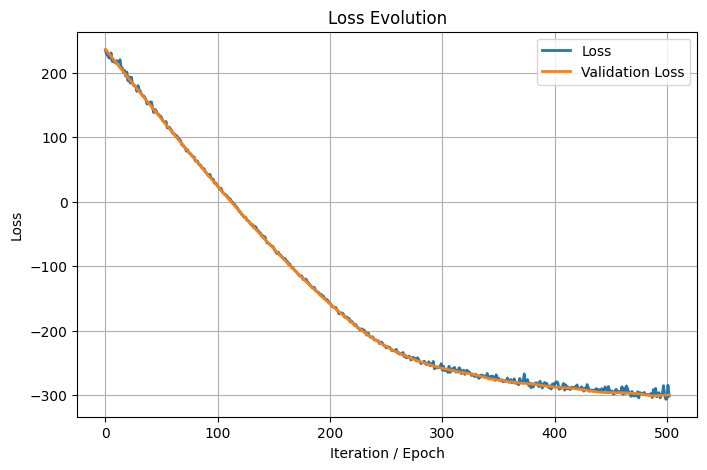

In [ ]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.4220e+00,  1.4119e+00,  1.3872e+00,  1.3828e+00,  1.3748e+00,
         1.8986e+00,  1.5248e+00,  8.7020e-01,  1.5411e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -9.2293e+00,  1.2094e+00,  1.1348e+00,
         1.1868e+00,  1.2835e+00,  1.3587e+00,  1.1421e+00,  1.1157e+00,
         1.7003e+00,  2.2890e+00,  1.6411e+00,  1.6411e+00, -3.4291e-02,
         2.8014e-02,  4.2688e-02, -2.6443e-02,  1.2380e-01, -1.0466e-01,
         2.0001e-01,  7.3320e-02,  2.9906e-01,  3.0909e-01,  3.9440e-01,
         3.0919e-01,  2.4190e-01,  2.8724e-01,  8.6841e-02,  3.3373e-02,
         2.1438e-01,  2.7684e-02,  1.1645e-01, -6.9889e-02, -1.1033e-01,
         5.3330e-01,  5.4352e-01,  4.1193e-01,  4.8174e-01,  1.8616e-01,
         9.4608e-02,  8.2072e-02,  8.3434e-02, -1.4924e-02, -3.4628e-02,
        -7.5199e-02, -1.1151e-01, -2.3328e-01, -2.7843e-01, -5.9788e-02,
        -7.8618e-02, -8.4579e-02, -3.3883e-02, -8.2989e-02, -1.1641e-02,
         3.4336e-02,  1.0738e-02, -9.9126e-

In [13]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [14]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [15]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [ ]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.9014
KLD Gaussian Train Data:  0.1089
KLD Copula   Train Data:  -0.0002
KLD GTM      Test  Data:  0.9178
KLD Gaussian Test  Data:  0.1097
KLD Copula   Test  Data:  0.0006


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

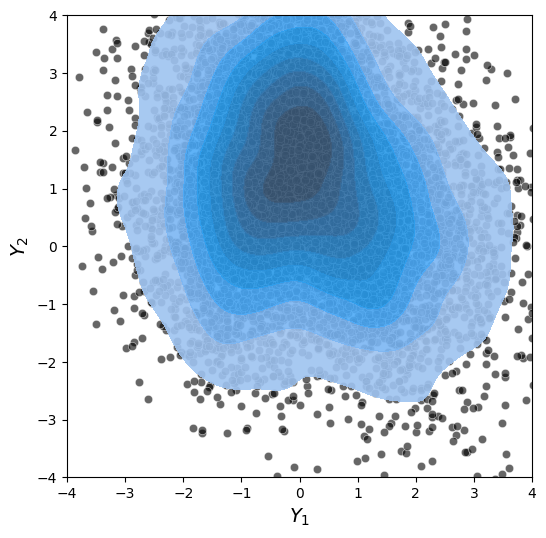

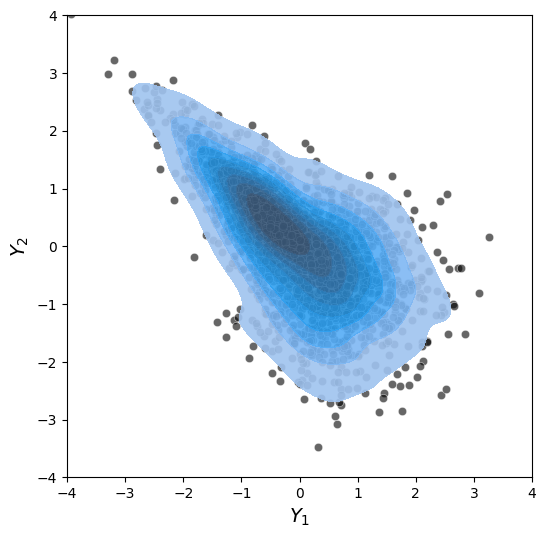

In [20]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [21]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


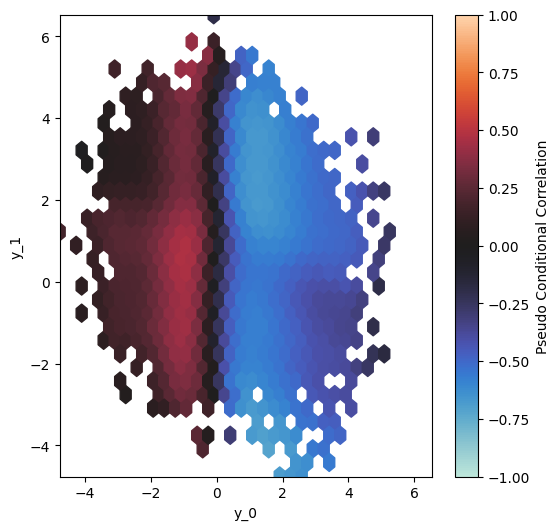

In [22]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


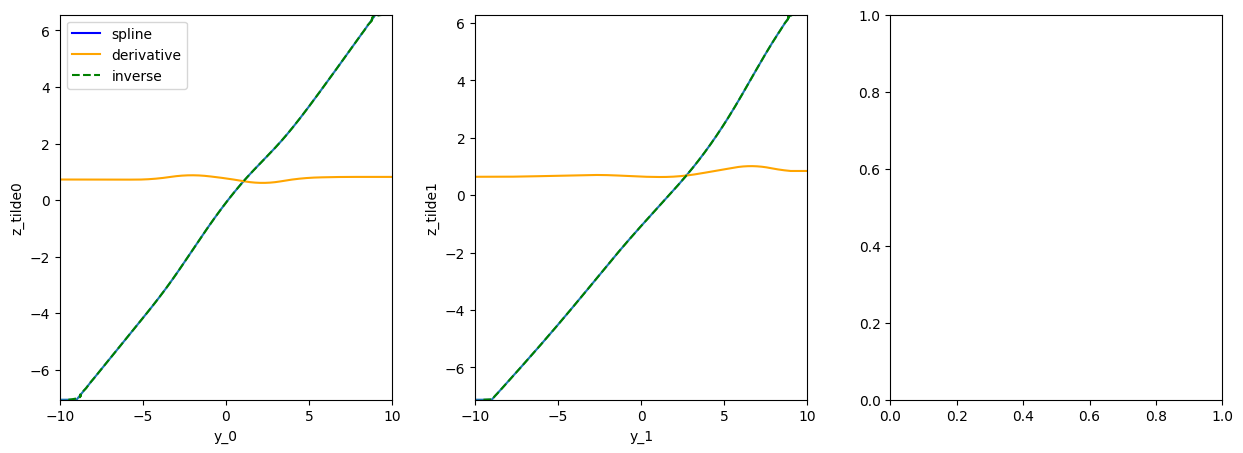

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


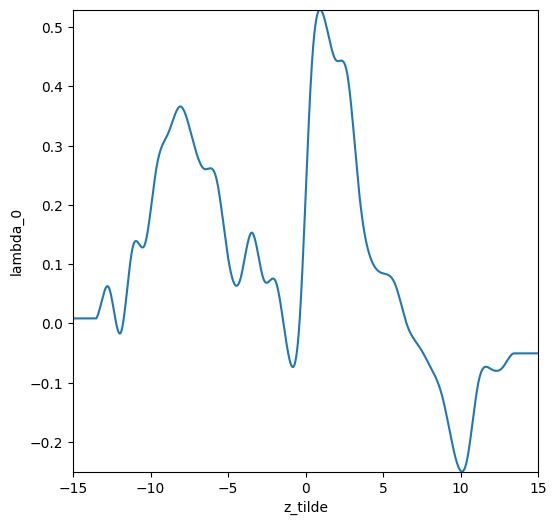

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


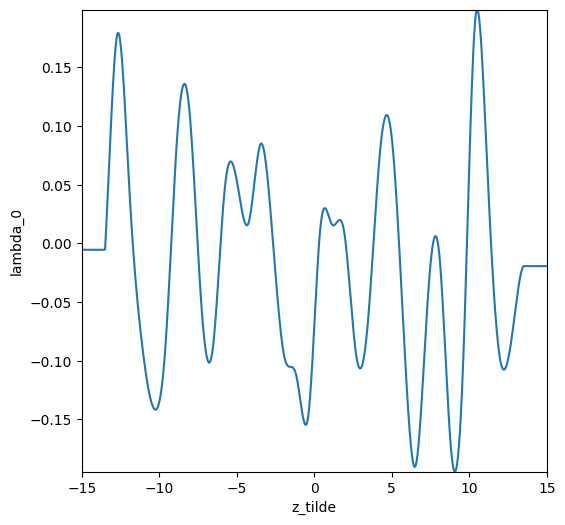

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


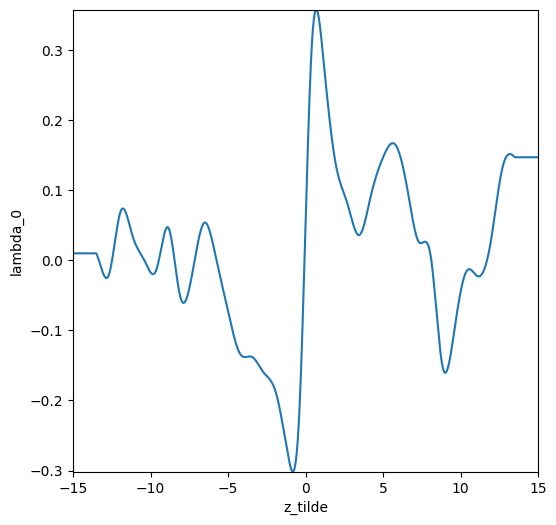

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)